
## All necessary imports

In [1]:
# !cd tools/ && python setup_opera_distance_metric.py build_ext --inplace

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Sequential
from torch.distributions import Bernoulli
from torch.nn.utils import clip_grad_norm_
import pyro
import pyro.distributions as dist
from itertools import product
import pickle
from collections import deque
from random import shuffle

from tools.opera_distance_metric import generate_k_nearest_graph, \
                                        opera_distance_metric_py, \
                                        generate_radius_graph

from graph_rnn import bfs_seq, encode_adj, decode_adj

from torch.nn.utils.rnn import pack_padded_sequence, pack_sequence, pad_sequence, pad_packed_sequence
import random
from collections import namedtuple

matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")


device = torch.device('cuda:3')

SCALE_SPATIAL = 1e5

In [3]:
def logsumexp(x, dim):
    x_max, _ = x.max(dim=dim,keepdim=True)
    x_max_expand = x_max.expand(x.size())
    res =  x_max + torch.log((x-x_max_expand).exp().sum(dim=dim, keepdim=True))
    return res

class GaussianMixtureNetwork(nn.Module):
    def __init__(self, input_dim, mixture_size, targets):
        super(GaussianMixtureNetwork, self).__init__()
        self.input_dim = input_dim
        self.mixture_size = mixture_size
        self.targets = targets
        self.logsoftmax = nn.LogSoftmax(dim=2)
        self.softmax = nn.Softmax(dim=2)
        self.TWO = torch.tensor(2., dtype=torch.float32).to(device)
        self.ADDITIVE_TERM = torch.tensor(-0.5 * np.log(np.pi*2), dtype=torch.float32).to(device)
        self.alphas = nn.Linear(input_dim, mixture_size * targets)
        self.sigmas = nn.Linear(input_dim, mixture_size * targets)
        self.means = nn.Linear(input_dim, mixture_size * targets)
        
    def forward(self, inputs):
        alphas = self.alphas(inputs).view(-1, self.targets, self.mixture_size)
        log_sigmas = self.sigmas(inputs).view(-1, self.targets, self.mixture_size)
        means = self.means(inputs).view(-1, self.targets, self.mixture_size)
        return alphas, means, torch.clamp_min(log_sigmas, -5)
    
    def logits(self, inputs, target):
        """
        inputs = [N, input_dim]
        target = [N, K]
        """
        # alphas, means, sigmas = [N, K, mixture_size]
        alphas, means, log_sigmas = self.forward(inputs)
        

        log_alphas = self.logsoftmax(alphas)
        log_pdf =  self.ADDITIVE_TERM - log_sigmas - (((target.unsqueeze(-1) - means)) / log_sigmas.exp()).pow(2) / self.TWO
        logits = logsumexp(log_alphas + log_pdf, dim=-1).view(-1, self.targets)
        return logits
    
    def generate(self, inputs):
        # alphas, means, sigmas = [N, K, mixture_size]
        alphas, means, log_sigmas = self.forward(inputs)
        alphas = self.softmax(alphas)
        # alphas_picked = [N, K]
        alphas_sampled = pyro.sample("alphas", dist.Categorical(alphas))
        sigmas = log_sigmas.exp()
        result = pyro.sample("preds", dist.Normal(
            torch.gather(means.view(-1, self.mixture_size), dim=1, index=alphas_sampled.view(-1, 1)).view(-1, self.targets),
            torch.gather(sigmas.view(-1, self.mixture_size), dim=1, index=alphas_sampled.view(-1, 1)).view(-1, self.targets)
        ))
        return result

In [4]:
shower_adj = namedtuple('shower_adj', field_names=['x', 'adj', 'ele_p'])
showers = pickle.load(open("./data/showers_ship_2gev_big.pkl", "rb"))

In [5]:
def bfs_handmade(G, start):
    visited, queue = set(), deque([start])
    bfs = []
    while queue: 
        vertex = queue.popleft()
        bfs.append(vertex)
        edges = [x[1] for x in G.edges(vertex, data=True)]; shuffle(edges)
        # edges = sorted(G.edges(vertex, data=True), key=lambda x: x[2]['weight']); edges = [x[1] for x in edges]
        for neighbour in edges: 
            if neighbour not in visited: 
                visited.add(neighbour) 
                queue.append(neighbour) 
                
    return bfs

In [6]:
DISTANCE = 1293. / SCALE_SPATIAL
EPS = 1e-5
def opera_distance_metric(basetrack_left, basetrack_right):
    # x, y, z, tx, ty
    # 0, 1, 2, 3, 4
    mask_swap = (basetrack_right[:, 2] < basetrack_left[:, 2])
    basetrack_right[mask_swap], basetrack_left[mask_swap] = basetrack_left[mask_swap], basetrack_right[mask_swap]
    dz = basetrack_right[:, 2] - basetrack_left[:, 2]
    
    dx = basetrack_left[:, 0] - (basetrack_right[:, 0] - basetrack_right[:, 3] * dz)
    dy = basetrack_left[:, 1] - (basetrack_right[:, 1] - basetrack_right[:, 4] * dz)
    
    dtx = basetrack_left[:, 3] - basetrack_right[:, 3]
    dty = basetrack_left[:, 4] - basetrack_right[:, 4]
    
    # dz = DISTANCE
    a = (dtx).pow(2) + (dty).pow(2)
    b = 2 * (dtx * dx +  dty * dy)
    c = dx.pow(2) + dy.pow(2)
    
    mask = (a == torch.tensor(0., dtype=torch.float32).to(device))
    result = torch.zeros_like(a)
    result[mask] = (torch.abs(torch.sqrt(c)) * dz / DISTANCE)[mask]
    
    a = a[~mask]
    b = b[~mask]
    c = c[~mask]
    discriminant = (b ** 2. - 4. * a * c)
    log_denominator = 2. * torch.sqrt(a) * torch.sqrt(torch.abs((a * dz + b) * dz + c)) + 2 * a * dz + b + EPS
    log_numerator = 2. * torch.sqrt(a) * torch.sqrt(c) + b + EPS
    first_part = ( (2. * a * dz + b) * torch.sqrt(torch.abs(dz * (a * dz + b) + c)) - b * torch.sqrt(c) ) / (4. * a)
    result[~mask] = torch.abs((discriminant * torch.log(torch.abs(log_numerator / log_denominator)) / (8. * torch.sqrt(a * a * a)) + first_part)) / DISTANCE
    
    return result

In [7]:
def encode_adj(adj, max_prev_node=10, is_full=False):
    '''
    :param adj: n*n, rows means time step, while columns are input dimension
    :param max_degree: we want to keep row number, but truncate column numbers
    :return:
    '''
    if is_full:
        max_prev_node = adj.shape[0] - 1
    
    # pick up lower tri
    adj = np.tril(adj, k=-1)
    n = adj.shape[0]
    adj = adj[1:n, 0:n-1]

    # use max_prev_node to truncate
    # note: now adj is a (n-1) * (n-1) matrix
    adj_output = np.zeros((adj.shape[0], max_prev_node))
    for i in range(adj.shape[0]):
        input_start = max(0, i - max_prev_node + 1)
        input_end = i + 1
        output_start = max_prev_node + input_start - input_end
        output_end = max_prev_node
        adj_output[i, output_start:output_end] = adj[i, input_start:input_end]
        adj_output[i,:] = adj_output[i,:][::-1] # reverse order

    return adj_output

## Model parameters

In [8]:
graphrnn_shower = namedtuple('graphrnn_shower', field_names=['x', 
                                                             'adj', 
                                                             'adj_out', 
                                                             'node_weights',
                                                             'node_in_degree',
                                                             'node_out_degree',
                                                             'ele_p',
                                                             'edge_weights'])

In [9]:
def drop_nodes(G, probability=0.1):
    nodes = list(G.nodes())[1:]
    droped_nodes = np.random.choice(nodes, size=int(probability * len(nodes)), replace=False)
    for node in droped_nodes:
        G.add_edges_from(list(product(list(G.predecessors(node)), list(G.successors(node)))))
        G.remove_node(node)
    return G, droped_nodes

In [10]:
def shower_rotation(X):
    theta = np.random.uniform(0, 2 * np.pi)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s), (s, c)))
    X[:, [1, 2]] = X[:, [1, 2]].dot(R)
    X[:, [4, 5]] = X[:, [4, 5]].dot(R)
    return X

In [11]:
def preprocess_shower_for_graphrnn(shower, device, 
                                   probability=0.1, 
                                   debug=False):
    X = np.vstack([
        np.arange(len(shower.x.SX)),
        shower.x.SX,
        shower.x.SY,  
        shower.x.SZ, 
        shower.x.TX,
        shower.x.TY]
    ).T.copy()
    
    X = shower_rotation(X)
    #G = nx.DiGraph(shower.adj)
    # not symmetric by construction(i.e.) tree 
    # need symmetrization
    G = nx.bfs_tree(nx.Graph(shower.adj), 0)
    G, droped_nodes = drop_nodes(G, probability=probability)
    mask = np.ones(len(X), bool)
    mask[droped_nodes] = False
    X = X[mask]
    
    G = nx.Graph(G) # track dropout
    adj = np.asarray(nx.to_numpy_matrix(G)) # shower.adj.copy() #

    # here is ok to be DiGraph, becuase in bfs_handmade used edges
    G = nx.DiGraph(adj)
    # add randomness in bfs?
    start_idx = 0
    x_idx = np.array(bfs_handmade(G, start_idx))

    adj = adj[np.ix_(x_idx, x_idx)]
    
    G = nx.bfs_tree(nx.Graph(adj), 0)
    
    node_degrees = dict(G.degree())
    node_in_degree = list(G.in_degree())
    node_in_degree = sorted(node_in_degree, key=lambda x: x[0])
    node_in_degree = torch.tensor([nid[1] for nid in node_in_degree], dtype=torch.float32).to(device)
    
    node_out_degree = list(G.out_degree())
    node_out_degree = sorted(node_out_degree, key=lambda x: x[0])
    node_out_degree = torch.tensor([nod[1] for nod in node_out_degree], dtype=torch.float32).to(device)
    
    edge_weights = []
    for i, j in G.edges():
        edge_weights.append( np.exp(-2 * np.abs((node_degrees[i] + node_degrees[j]) / 4 - 1)) )

    node_weights = [d for n, d in G.degree()]
    node_weights = torch.tensor(node_weights, dtype=torch.float32).view(-1).to(device)
    
    # actual data
    adj_output = encode_adj(adj, max_prev_node=max_prev_node)
    
    if debug:
        adj_recover = decode_adj(adj_output)
        return np.abs((adj_recover - adj)).sum()
    
    
    X = X[x_idx, 1:]
    X = X / np.array([SCALE_SPATIAL, SCALE_SPATIAL, SCALE_SPATIAL, 1, 1])
    
    # for now forget about distances
    # TODO: what to do with distances?
    adj_output[adj_output!=0] = 1.
    
    adj_output_t = torch.tensor(np.append(np.ones((1, max_prev_node)), 
                                          adj_output, axis=0), 
                                dtype=torch.float32).view(1, -1, max_prev_node).to(device)
    
    X_t = torch.tensor(X, dtype=torch.float32).view(1, -1, 5).to(device)

    
    adj_decoded = decode_adj(adj_output)
    
    # adj in/out
    adj_decoded[np.tril_indices_from(adj_decoded)] = 0
    G = nx.Graph(adj_decoded)
    edges = list(nx.bfs_edges(G, 0))
    # print(edges)
    # return 

    adj_out_t = torch.LongTensor(np.array(edges).T).to(device)
    
    adj_squared_t = torch.tensor(adj, dtype=torch.float32).to(device)
    
    return graphrnn_shower(adj=adj_output_t, 
                           x=X_t, 
                           node_weights=node_weights,
                           adj_out=adj_out_t,
                           node_in_degree=node_in_degree.view(-1, 1),
                           node_out_degree=node_out_degree.view(-1, 1),
                           edge_weights=torch.tensor(edge_weights, 
                                                     dtype=torch.float32).view(-1, 1).to(device),
                           ele_p=torch.tensor(shower.ele_p, dtype=torch.float32).to(device))

In [12]:
from torch.utils.data.dataset import Dataset

class TorchShowers(Dataset):
    def __init__(self, showers, device, probability):
        self.showers = showers
        self.probability = probability
        self.device = device
    def __getitem__(self, index):
        return preprocess_shower_for_graphrnn(self.showers[index], device=self.device,
                                              probability=self.probability)

    def __len__(self):
        return len(self.showers)

In [13]:
max_prev_node = 8

def collate_fn(x):
    return x

dataset_loader = torch.utils.data.DataLoader(TorchShowers(showers, device=device,
                                                          probability=0.05), batch_size=300, 
                                             shuffle=True, 
                                             num_workers=0,
                                             collate_fn=collate_fn)

In [14]:
from IPython.display import clear_output
for shower in tqdm(dataset_loader):
    print(len(shower))

300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
93



In [15]:
debuged_recovery_rate = []
for shower in tqdm(showers):
    debuged_recovery_rate.append(preprocess_shower_for_graphrnn(shower=shower, device=None, debug=True))
print(np.unique(debuged_recovery_rate, return_counts=True))


(array([ 0.,  2.,  4.,  8., 10., 12., 16., 18., 20., 24., 26., 30., 34.,
       36., 42., 46., 48., 52., 54., 56., 60., 62., 64., 70., 72., 76.,
       78., 80., 86., 88.]), array([9948,    2,    1,    1,    1,    1,    2,    1,    3,    2,    1,
          1,    1,    1,    2,    3,    2,    1,    1,    2,    3,    1,
          1,    1,    1,    3,    3,    1,    1,    1]))


#### GraphRNN 

Generates embeddings for nodes.

In [16]:
class GraphRNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, 
                 num_layers, has_input=True, has_output=False, output_size=None):
        super(GraphRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.has_input = has_input
        self.has_output = has_output

        if has_input:
            self.input = nn.Linear(input_size, embedding_size)
            self.rnn = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, 
                              num_layers=num_layers, batch_first=True, dropout=0.35)
        else:
            self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                              num_layers=num_layers, batch_first=True, dropout=0.35)
        if has_output:
            self.output = nn.Sequential(
                nn.Linear(hidden_size, embedding_size),
                nn.ReLU(),
                nn.Linear(embedding_size, output_size)
            )

        self.relu = nn.ReLU()
        # initialize
        self.hidden_emb = nn.Sequential(
            nn.Linear(1, self.hidden_size)
        )
        self.hidden = None  # need initialize before forward run

    def init_hidden(self, input, batch_size):
        hidden_emb = torch.cat([self.hidden_emb(input).view(1, batch_size, self.hidden_size), 
                                torch.zeros(self.num_layers - 1, batch_size, self.hidden_size).to(device)])
        return hidden_emb

    def forward(self, input_raw, pack=False, input_len=None):
        # input_raw = [batch_size, seq_length, input_size]
        output_raw_emb, output_raw, output_len = None, None, None
        
        if self.has_input:
            input = self.input(input_raw)
            input = self.relu(input)
        else:
            input = input_raw
        if pack:
            pass # input = pack_sequence(input)
        
        # output_raw_emb = [batch_size, seq_length, output_size]
        output_raw_emb, self.hidden = self.rnn(input, self.hidden)
        if pack:
            output_raw_emb, output_len = pad_packed_sequence(output_raw_emb, batch_first=True)
        
        if self.has_output:
            output_raw = self.output(output_raw_emb)
            
        if pack:
            output_raw_packed = pack_padded_sequence(output_raw, lengths=output_len, batch_first=True)
            return output_raw_emb, output_raw, output_len
        
        # return hidden state at each time step
        return output_raw_emb, output_raw, output_len

### FeaturesGCN

In [17]:
import torch_geometric.transforms as T
import torch_cluster
import torch_geometric

from torch_geometric.nn import NNConv, GCNConv, GraphConv
from torch_geometric.nn import PointConv, EdgeConv, SplineConv


class FeaturesGCN(torch.nn.Module):
    def __init__(self, dim_in, embedding_size=128, 
                 num_layers_gcn=3, 
                 num_layers_dense=4, 
                 dim_out=5, 
                 mixture_size=5, 
                 agg='mean'):
        super().__init__()

        self.wconv_in = EdgeConv(Sequential(nn.Linear(dim_in * 2, embedding_size), 
                                            nn.Dropout(p=0.5), 
                                            nn.Tanh()), agg)
        
        self.layers_gcn = nn.ModuleList(modules=[EdgeConv(
            Sequential(
                nn.Linear(embedding_size * 2, embedding_size), 
                nn.Dropout(p=0.5), 
                nn.Tanh()
            ), 
            agg) for i in range(num_layers_gcn)])
        
        self.layers_dense = nn.ModuleList([
            Sequential(nn.Linear(embedding_size, embedding_size), 
                       nn.Tanh())
            for i in range(num_layers_dense)
        ])
        
        self.out = GaussianMixtureNetwork(embedding_size * 2, mixture_size, targets=dim_out)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # x = self.bn1(x)
        x = self.wconv_in(x=x, edge_index=edge_index)
        
        for l in self.layers_gcn:
            x = l(x=x, edge_index=edge_index)
            
        for l in self.layers_dense:
            x = l(x)
        
        x = torch.cat([torch.index_select(x, dim=0, index=edge_index[0]), 
                       torch.index_select(x, dim=0, index=edge_index[1])], dim=1)

        # x = self.bn2(x)
        return x, edge_index
    
    def get_distr(self, data):
        x, edge_index = self.forward(data)
        return self.out(x)
        
    def logits(self, data, target):
        x, edge_index = self.forward(data)
        logits = self.out.logits(x, torch.index_select(target, dim=0, index=edge_index[1]) - torch.index_select(target, dim=0, index=edge_index[0]))
        _, _, log_sigmas = self.out(x)
        return logits, log_sigmas.exp()
    
    def generate(self, data):
        x, edge_index = self.forward(data)
        return self.out.generate(x)

#### Losses

In [18]:
sigmoid = nn.Sigmoid().to(device)
loss_bce = nn.BCELoss(reduction='none').to(device)
loss_mse = torch.nn.MSELoss().to(device)

def loss_mse_edges(shower, features):
    return loss_mse((shower.x[0][shower.adj_out[0]] - shower.x[0][shower.adj_out[1]]), 
                    (features[shower.adj_out[0]] - features[shower.adj_out[1]]))

### init

In [19]:
embedding_size = 196
edge_rnn_embedding_size = 32

model = GraphRNN(input_size=max_prev_node, 
                 embedding_size=embedding_size, # embedding_size of linear layer
                 output_size=edge_rnn_embedding_size, 
                 has_output=True, 
                 hidden_size=embedding_size, 
                 num_layers=4, 
                 has_input=False).to(device)

edge_nn = GraphRNN(input_size=1, 
                   embedding_size=edge_rnn_embedding_size,
                   hidden_size=edge_rnn_embedding_size, 
                   num_layers=4, 
                   has_input=True, 
                   has_output=True, 
                   output_size=1).to(device)


features_nn = FeaturesGCN(dim_in=embedding_size + 2, 
                          embedding_size=8, 
                          num_layers_gcn=2, 
                          num_layers_dense=0,
                          mixture_size=4,
                          dim_out=5).to(device=device)

In [20]:
from torch.nn.utils.rnn import PackedSequence
ZERO = torch.tensor(0., dtype=torch.float32).to(device)
def concat_padded_tensors(tensor, lengths):
    return torch.cat([tensor[i, :length, :][1:, :] for i, length in enumerate(lengths)], dim=0)

def process_train_graphrnn(showers_batch):
    batch_size = len(showers_batch)
    
    model.hidden = model.init_hidden(input=torch.stack([ZERO for x in showers_batch]).view(-1, 1), 
                                     batch_size=batch_size)
    # weights
    weights = torch.cat([x.node_weights[1:] for x in showers_batch])
    
    # x.adj = [N, max_nodes]
    # packed_adj_batch = [batch_size, N_max, max_nodes]
    # print('adj', showers_batch[0].adj.shape, showers_batch[1].adj.shape)
    packed_adj_batch = pack_sequence([x.adj[0] for x in showers_batch])
    # print(pad_packed_sequence(packed_adj_batch, batch_first=True)[0][0])
    
    # print(packed_adj_batch.shape)
    # embedding_batch -- padded [batch_size, N_max, hidden_size]
    embedding_batch_raw, embedding_batch, output_len = model(packed_adj_batch, pack=True)
    
    # shower embedding_batch[i, :output_len[i], :]
    packed_embedding_batch = concat_padded_tensors(embedding_batch, output_len)
    packed_adj_batch = torch.cat([x.adj[0][1:] for x in showers_batch], dim=0)
    # print(packed_adj_batch.shape, packed_embedding_batch.shape)
    
    hidden_null = torch.zeros(edge_nn.num_layers - 1, 
                              packed_embedding_batch.shape[0], 
                              packed_embedding_batch.shape[1]).to(device)
    
    edge_nn.hidden = torch.cat((packed_embedding_batch.view(
        1, 
        packed_embedding_batch.size(0), 
        packed_embedding_batch.size(1)
    ), hidden_null), dim=0)
    
    # packed_adj_batch_data = [total_edges, max_num_nodes, 1] // [batch_size, seq_length, input_size]
    packed_adj_batch = packed_adj_batch.view(packed_adj_batch.shape[0], 
                                             packed_adj_batch.shape[1], 1)
    
    # 
    packed_adj_batch = torch.cat((torch.ones(packed_adj_batch.shape[0], 1, 1).to(device), 
                                  packed_adj_batch), dim=1)
    edges_emb, edges, _ = edge_nn(packed_adj_batch)
    
    sliding_index = np.cumsum(np.concatenate([[0], output_len.numpy() - 1])).astype(int)
    # edges_emb_sliced = []
    
    # sliding_index[idx]][:, :-1, :]
    # TODO: not forget
    #for idx in range(1, len(sliding_index)):
    #    edges_emb_sliced.append(edges_emb[sliding_index[idx - 1]:
    #                                      sliding_index[idx]][:, 1:, :].contiguous().view(sliding_index[idx] - sliding_index[idx - 1], -1))
    
    # print(packed_adj_batch[:, 0, 0])
    loss_bc = loss_bce(torch.sigmoid(edges[:, :-1, :]), packed_adj_batch[:, 1:, :])
    loss_bc = (loss_bc.sum(dim=1).view(-1) * weights).mean()
    
    return embedding_batch_raw, \
           output_len, \
           loss_bc

### Optimization of edge predictions

In [21]:
from itertools import chain
SCALE_SPATIAL = 1e5

In [22]:
def loss_edges(shower_t, node_weights):
    x = features_nn.generate(shower_t)
    predictions = torch.zeros(len(shower_t.x), 5).to(device)
    for i, (j, k) in enumerate(shower_t.edge_index.t()):
        predictions[k] = predictions[j] + x[i]
    
    # loss_z = torch.remainder(predictions[:, 2], 1293. / SCALE_SPATIAL).pow(2).mean().sqrt()
    # loss_z = torch.remainder(x[:, 2], 1293. / SCALE_SPATIAL).pow(2).mean().sqrt()
    # weights = (torch.index_select(node_weights, dim=0, index=shower_t.edge_index[0]) + 
    #            torch.index_select(node_weights, dim=0, index=shower_t.edge_index[1])) / 2.
    node_from = torch.index_select(predictions, dim=0, index=shower_t.edge_index[0])
    node_to = torch.index_select(predictions, dim=0, index=shower_t.edge_index[1])
    smoothness = torch.mean(opera_distance_metric(node_from, node_to)) * SCALE_SPATIAL
    IP_left = loss_mse(node_from[:, -2:] * x[:, 2:3], x[:, :2]) * SCALE_SPATIAL
    IP_right = loss_mse(node_to[:, -2:] * x[:, 2:3], x[:, :2]) * SCALE_SPATIAL
    # TODO: special loss!
    return smoothness, IP_left, IP_right

In [23]:
MINUS_ONE = torch.tensor(-1., dtype=torch.float32).to(device)
def train_epoch(model, edge_nn, features_nn, dataset_loader, optimizer, weights={}, signal_gen=True):
    model.train()
    edge_nn.train()
    features_nn.train()
    loss_average_bce = []
    loss_average_logits = []
    loss_average_sigmas = []
    loss_smoothness = []
    loss_IP_left = []
    loss_IP_right = []
    for showers_batch in tqdm(dataset_loader):
        optimizer.zero_grad()
        showers_batch = sorted(showers_batch, key=lambda x: -x.adj.shape[1])

        embedding_batch, output_len, ll_bce = process_train_graphrnn(showers_batch)
        # print(embedding_batch.shape, edges_emb[0].shape, edges_emb[1].shape)
        # print(embedding_batch[0], output_len)
        ll_logits = []
        ll_sigmas = []
        ll_smoothness = []
        ll_IP_right = []
        ll_IP_left = []
        if signal_gen:
            # iterate over showers in batch and calc losses
            showers_t = []
            showers_x = []
            for k, l in enumerate(output_len):
                shower = showers_batch[k]
                embedding = embedding_batch[k, :output_len[k]]
                embedding = torch.cat([embedding, shower.node_in_degree, shower.node_out_degree], 1)
                # teacher forcing()
                showers_t.append(torch_geometric.data.Data(x=embedding, 
                                                           edge_index=shower.adj_out,
                                                           edge_attr=shower.edge_weights).to(device))
                showers_x.append(shower.x[0])
            big_shower_t = torch_geometric.data.Batch.from_data_list(showers_t)
            # GCN to recover shower features
            logits, sigmas = features_nn.logits(big_shower_t, torch.cat(showers_x))
            ll_logits = -torch.mean(torch.sum(logits, dim=1) * big_shower_t.edge_attr)
            ll_sigmas = torch.mean(torch.sum(sigmas, dim=1))
            # features prediction loss
            # minus
            # print(logits)
            # smoothness, IP_left, IP_right = loss_edges(big_shower_t, shower.node_weights)
            
            ll_IP_right = MINUS_ONE
            ll_IP_left = MINUS_ONE
            ll_smoothness = MINUS_ONE
            #ll_smoothness = smoothness
            #ll_IP_right = IP_right
            #ll_IP_left = IP_left
            #
            #ll_sigmas = torch.mean(torch.sum(sigmas, dim=1))
        else:
            ll_logits = MINUS_ONE
            ll_sigmas = MINUS_ONE
            ll_IP_right = MINUS_ONE
            ll_IP_left = MINUS_ONE
            ll_smoothness = MINUS_ONE
        
        # print(ll_logits)
        loss_average_bce.append(ll_bce.item())
        loss_average_logits.append(ll_logits.item())
        loss_average_sigmas.append(ll_sigmas.item())
        loss_smoothness.append(ll_smoothness.item())
        loss_IP_left.append(ll_IP_left.item())
        loss_IP_right.append(ll_IP_right.item())
        
        # loss_total = 
        (weights['ll_bce'] * ll_bce + \
         weights['ll_logits'] * ll_logits + \
         weights['ll_sigmas'] * ll_sigmas + \
         weights['ll_smoothness'] * ll_smoothness + \
         weights['ll_IP_right'] * ll_IP_right + \
         weights['ll_IP_left'] * ll_IP_left ).backward()
        # torch.nn.utils.clip_grad_value_(optimizer.param_groups[0]['params'], 0.2)
        optimizer.step()
    
    return np.mean(loss_average_bce), np.mean(loss_average_logits), np.mean(loss_average_sigmas), \
           np.mean(loss_smoothness), np.mean(loss_IP_left), np.mean(loss_IP_right)

In [24]:
PATH = './model/'

In [25]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(font_scale=1)

def plot_graphs(losses):
    # Create 2x2 sub plots
    fig, ax = plt.subplots(3, 2, figsize=(15, 15))
    ax = ax.ravel()
    for i, key in enumerate(losses.keys()):
        ax[i].plot(losses[key])
        ax[i].set_title(key)
    plt.show()

In [26]:
from IPython.display import clear_output

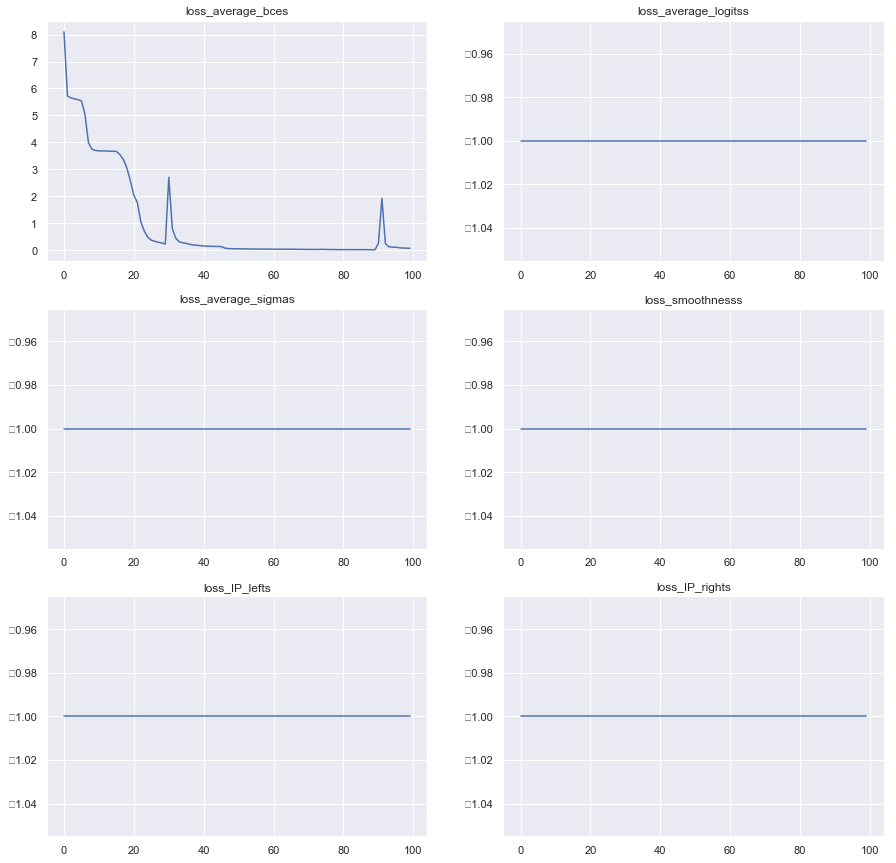

In [27]:
parameters = list(features_nn.parameters()) + list(model.parameters()) + list(edge_nn.parameters())
optimizer = torch.optim.Adam(list(model.parameters()) + 
                             list(edge_nn.parameters()), 
                                 lr=1e-3)

loss_average_bces = []
loss_average_logitss = []
loss_average_sigmas = []
loss_smoothnesss = []
loss_IP_lefts = []
loss_IP_rights = []
for epoch in tqdm(range(100)):
    loss_average_bce, \
    loss_average_logits, \
    loss_average_sigma, \
    loss_smoothness, \
    loss_IP_left, \
    loss_IP_right = train_epoch(model, 
                                edge_nn, 
                                features_nn,
                                dataset_loader, 
                                optimizer=optimizer, 
                                weights={
                                    'll_bce': 1., 
                                    'll_logits': 0.,
                                    'll_sigmas': 0.,
                                    'll_smoothness': 0,
                                    'll_IP_right': 0.,
                                    'll_IP_left': 0.
                                }, signal_gen=False)
    
    loss_average_bces.append(loss_average_bce)
    loss_average_logitss.append(loss_average_logits)
    loss_average_sigmas.append(loss_average_sigma)
    loss_smoothnesss.append(loss_smoothness)
    loss_IP_lefts.append(loss_IP_left)
    loss_IP_rights.append(loss_IP_right)
    if (epoch + 1) % 50 == 0:
        torch.save(model.state_dict(), open(PATH + 'graph_nn.pcl', 'wb+'))
        torch.save(edge_nn.state_dict(), open(PATH + 'edge_nn.pcl', 'wb+'))
        torch.save(features_nn.state_dict(), open(PATH + 'features_nn.pcl', 'wb+'))
    if epoch % 1 == 0:
        clear_output()
        plot_graphs({
            'loss_average_bces': loss_average_bces,
            'loss_average_logitss': loss_average_logitss,
            'loss_average_sigmas': loss_average_sigmas,
            'loss_smoothnesss': loss_smoothnesss,
            'loss_IP_lefts': loss_IP_lefts,
            'loss_IP_rights': loss_IP_rights
        })

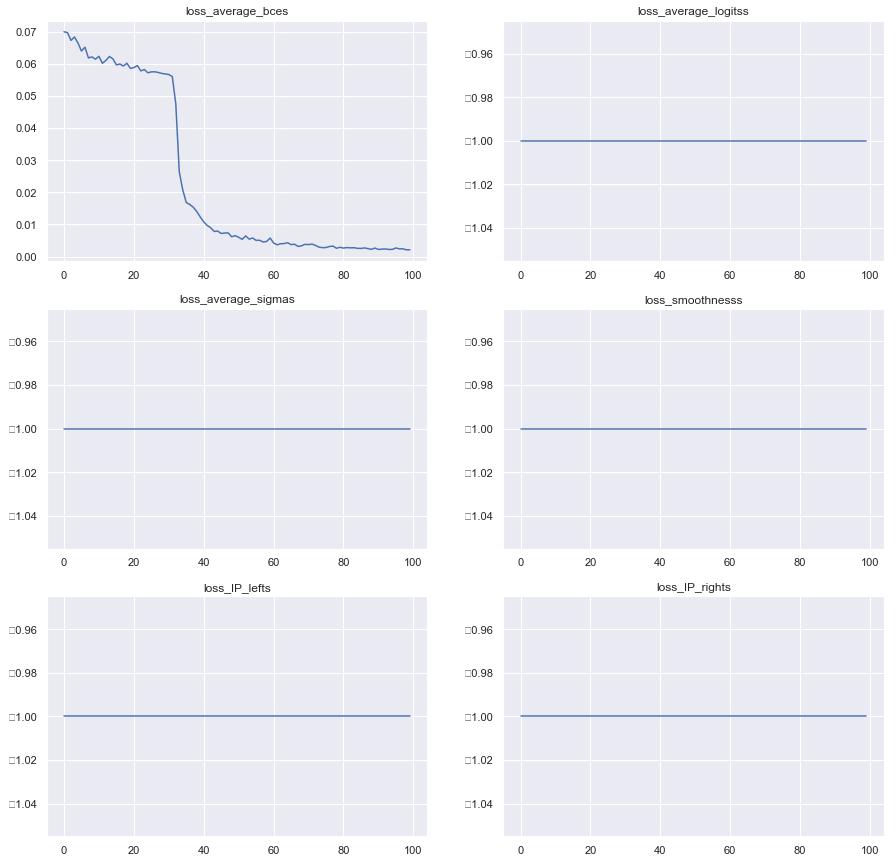

In [28]:
parameters = list(features_nn.parameters()) + list(model.parameters()) + list(edge_nn.parameters())
optimizer = torch.optim.Adam(list(model.parameters()) + 
                             list(edge_nn.parameters()),
                                 lr=1e-4)

loss_average_bces = []
loss_average_logitss = []
loss_average_sigmas = []
loss_smoothnesss = []
loss_IP_lefts = []
loss_IP_rights = []
for epoch in tqdm(range(100)):
    loss_average_bce, \
    loss_average_logits, \
    loss_average_sigma, \
    loss_smoothness, \
    loss_IP_left, \
    loss_IP_right = train_epoch(model, 
                                edge_nn, 
                                features_nn,
                                dataset_loader, 
                                optimizer=optimizer, 
                                weights={
                                    'll_bce': 1., 
                                    'll_logits': 0,
                                    'll_sigmas': 0.,
                                    'll_smoothness': 0,
                                    'll_IP_right': 0.,
                                    'll_IP_left': 0.
                                }, signal_gen=False)
    
    loss_average_bces.append(loss_average_bce)
    loss_average_logitss.append(loss_average_logits)
    loss_average_sigmas.append(loss_average_sigma)
    loss_smoothnesss.append(loss_smoothness)
    loss_IP_lefts.append(loss_IP_left)
    loss_IP_rights.append(loss_IP_right)
    if (epoch + 1) % 50 == 0:
        torch.save(model.state_dict(), open(PATH + 'graph_nn.pcl', 'wb+'))
        torch.save(edge_nn.state_dict(), open(PATH + 'edge_nn.pcl', 'wb+'))
        torch.save(features_nn.state_dict(), open(PATH + 'features_nn.pcl', 'wb+'))
    if epoch % 1 == 0:
        clear_output()
        plot_graphs({
            'loss_average_bces': loss_average_bces,
            'loss_average_logitss': loss_average_logitss,
            'loss_average_sigmas': loss_average_sigmas,
            'loss_smoothnesss': loss_smoothnesss,
            'loss_IP_lefts': loss_IP_lefts,
            'loss_IP_rights': loss_IP_rights
        })

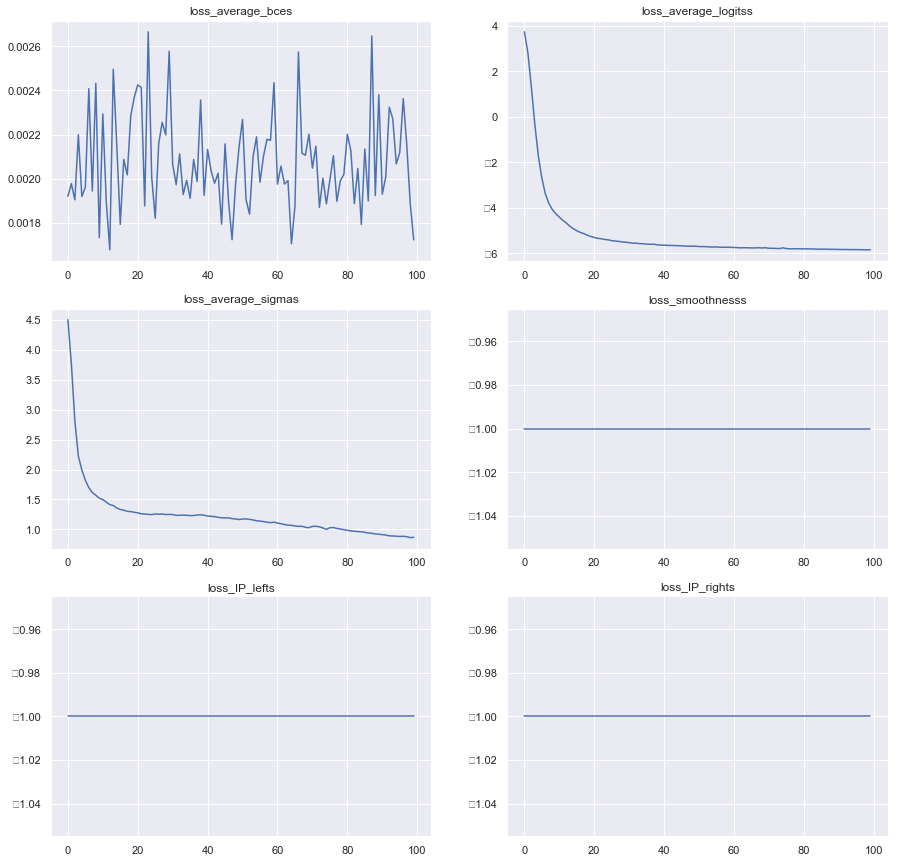

In [29]:
optimizer = torch.optim.Adam(list(features_nn.parameters()), 
                                 lr=1e-3)

loss_average_bces = []
loss_average_logitss = []
loss_average_sigmas = []
loss_smoothnesss = []
loss_IP_lefts = []
loss_IP_rights = []
for epoch in tqdm(range(100)):
    loss_average_bce, \
    loss_average_logits, \
    loss_average_sigma, \
    loss_smoothness, \
    loss_IP_left, \
    loss_IP_right = train_epoch(model, edge_nn, features_nn,
                                dataset_loader, 
                                optimizer=optimizer, 
                                weights={
                                    'll_bce': 0., 
                                    'll_logits': 1.,
                                    'll_sigmas': 0.,
                                    'll_smoothness': 0.,
                                    'll_IP_right': 0.,
                                    'll_IP_left': 0.
                                }, signal_gen=True)
    
    loss_average_bces.append(loss_average_bce)
    loss_average_logitss.append(loss_average_logits)
    loss_average_sigmas.append(loss_average_sigma)
    loss_smoothnesss.append(loss_smoothness)
    loss_IP_lefts.append(loss_IP_left)
    loss_IP_rights.append(loss_IP_right)
    if (epoch + 1) % 50 == 0:
        torch.save(model.state_dict(), open(PATH + 'graph_nn.pcl', 'wb+'))
        torch.save(edge_nn.state_dict(), open(PATH + 'edge_nn.pcl', 'wb+'))
        torch.save(features_nn.state_dict(), open(PATH + 'features_nn.pcl', 'wb+'))
    if epoch % 1 == 0:
        clear_output()
        plot_graphs({
            'loss_average_bces': loss_average_bces,
            'loss_average_logitss': loss_average_logitss,
            'loss_average_sigmas': loss_average_sigmas,
            'loss_smoothnesss': loss_smoothnesss,
            'loss_IP_lefts': loss_IP_lefts,
            'loss_IP_rights': loss_IP_rights
        })

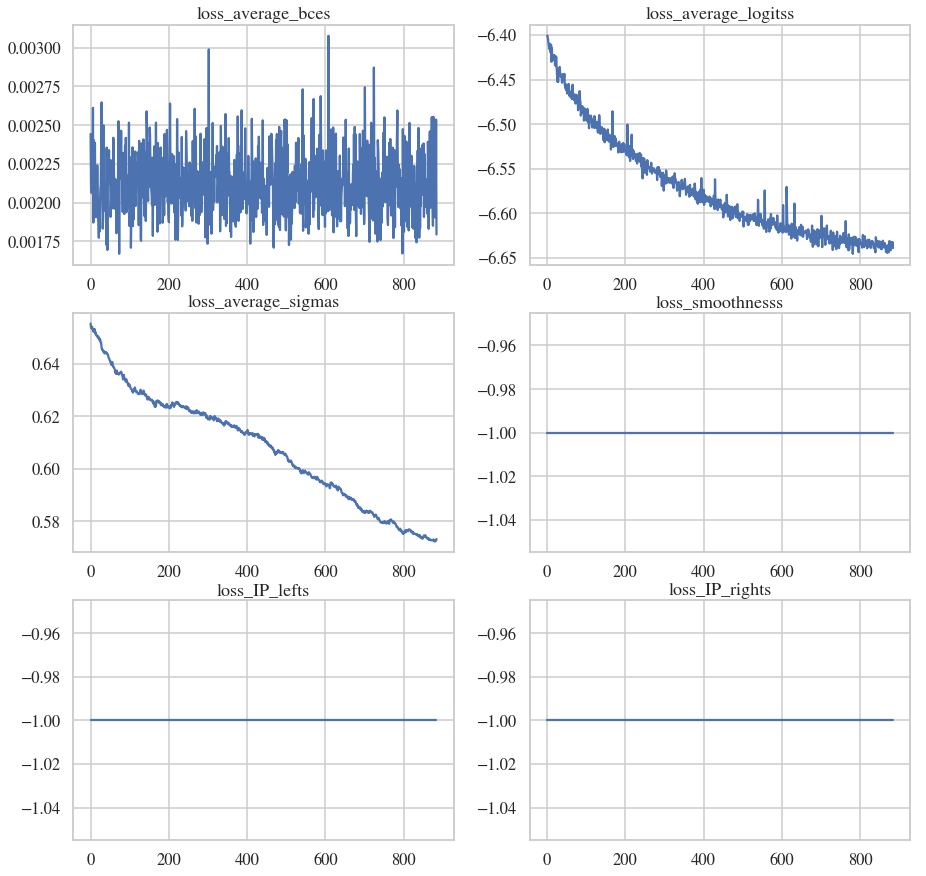

In [ ]:
optimizer = torch.optim.Adam(list(features_nn.parameters()), 
                                 lr=1e-4)

loss_average_bces = []
loss_average_logitss = []
loss_average_sigmas = []
loss_smoothnesss = []
loss_IP_lefts = []
loss_IP_rights = []
for epoch in tqdm(range(1000)):
    loss_average_bce, \
    loss_average_logits, \
    loss_average_sigma, \
    loss_smoothness, \
    loss_IP_left, \
    loss_IP_right = train_epoch(model, 
                                edge_nn, 
                                features_nn,
                                dataset_loader, 
                                optimizer=optimizer, 
                                weights={
                                    'll_bce': 0., 
                                    'll_logits': 1.,
                                    'll_sigmas': 0.1,
                                    'll_smoothness': 0.,
                                    'll_IP_right': 0.,
                                    'll_IP_left': 0.
                                }, signal_gen=True)
    
    loss_average_bces.append(loss_average_bce)
    loss_average_logitss.append(loss_average_logits)
    loss_average_sigmas.append(loss_average_sigma)
    loss_smoothnesss.append(loss_smoothness)
    loss_IP_lefts.append(loss_IP_left)
    loss_IP_rights.append(loss_IP_right)
    if (epoch + 1) % 50 == 0:
        torch.save(model.state_dict(), open(PATH + 'graph_nn.pcl', 'wb+'))
        torch.save(edge_nn.state_dict(), open(PATH + 'edge_nn.pcl', 'wb+'))
        torch.save(features_nn.state_dict(), open(PATH + 'features_nn.pcl', 'wb+'))
    if epoch % 1 == 0:
        clear_output()
        plot_graphs({
            'loss_average_bces': loss_average_bces,
            'loss_average_logitss': loss_average_logitss,
            'loss_average_sigmas': loss_average_sigmas,
            'loss_smoothnesss': loss_smoothnesss,
            'loss_IP_lefts': loss_IP_lefts,
            'loss_IP_rights': loss_IP_rights
        })

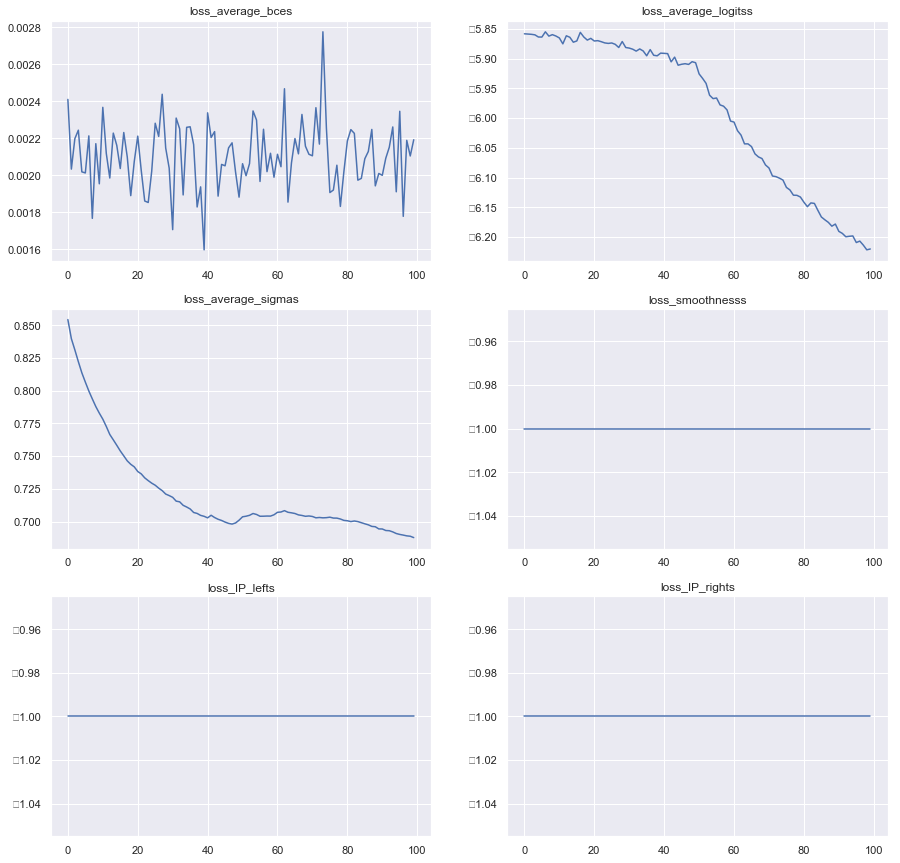

In [31]:
plot_graphs({
            'loss_average_bces': loss_average_bces,
            'loss_average_logitss': loss_average_logitss,
            'loss_average_sigmas': loss_average_sigmas,
            'loss_smoothnesss': loss_smoothnesss,
            'loss_IP_lefts': loss_IP_lefts,
            'loss_IP_rights': loss_IP_rights
        })

In [32]:
loss_average_logitss[-1]

-6.220180287080653

In [33]:
loss_average_bces[-1]

0.002192901372943786

## Optimization of feature reconstruction

In [57]:
def get_graph(adj):
    '''
    get a graph from zero-padded adj
    :param adj:
    :return:
    '''
    # remove all zeros rows and columns
    adj = adj[~np.all(adj == 0, axis=1)]
    adj = adj[:, ~np.all(adj == 0, axis=0)]
    adj = np.asmatrix(adj)
    G = nx.from_numpy_matrix(adj)
    return G

def generate_graph(model, edge_nn, max_prev_node, test_batch_energies, device):
    test_batch_size = test_batch_energies.shape[0]
    
    # hidden_state = [num_layers, batch_size, hidden_size]
    model.eval()
    edge_nn.eval()
    features_nn.eval()

    # generate graphs
    max_num_node = 80
    
    # предсказания нейронки сэмплированные с помощью бернулли
    # y_pred = [batch_size, seq_length, max_nodes]
    y_pred_long = torch.ones(test_batch_size, 
                             max_num_node, 
                             max_prev_node).to(device) # discrete prediction
    
    # x_step = [batch_size, 1, max_nodes]
    # x_step = [batch_size, seq_length, max_nodes]
    # seq_length == 1
    model.hidden = model.init_hidden(test_batch_energies, test_batch_size)
    x_step = torch.ones(test_batch_size, 1, max_prev_node).to(device)
    embs = []
    for i in tqdm(range(max_num_node)):
        # output_raw_emb, output_raw, output_len
        # h = [test_batch, seq_length, output_size] # seq_length = 1
        emb, h, _ = model(x_step)
        embs.append(emb)
        # hidden_state = [num_layers, batch_size, hidden_size]
        hidden_null = torch.zeros(edge_nn.num_layers - 1, h.size(0), h.size(2)).to(device)
        edge_nn.hidden = torch.cat((h.permute(1, 0, 2), hidden_null), dim=0)  # num_layers, batch_size, hidden_size
        # sampling x_step from output h
        x_step = torch.zeros(test_batch_size, 1, max_prev_node).to(device)
        output_x_step = torch.ones(test_batch_size, 1, 1).to(device)
        for j in range(max_prev_node):
            # edge_emb = [batch_size, seq_length, hidden_size]
            # output_y_pred_step = [batch_size, seq_length, 1]
            edge_emb, output_y_pred_step, _ = edge_nn(output_x_step)
            # if j: edges_emb.append(edge_emb)
            if j < i + 1:
                output_x_step = Bernoulli(probs=torch.sigmoid(output_y_pred_step)).sample()
                x_step[:, :, j:j+1] = output_x_step
            # edge_nn.hidden = hidden.data
        y_pred_long[:, i:i + 1, :] = x_step
    # TODO: need?
    emb, h, _ = model(x_step)
    embs.append(emb)
    
    embs = torch.cat(embs, dim=1)
    
    y_pred_long_data = y_pred_long.data.long()
    
    # save graphs as pickle
    # edges_emb = torch.cat(edges_emb, dim=1).view(test_batch_size, max_num_node, -1)
    # edges_emb = torch.cat([torch.ones(test_batch_size, 1, edges_emb.shape[2]).to(device), edges_emb], dim=1)
    
    showers = []
    
    for i in tqdm(range(test_batch_size)):
        plt.figure(figsize=(12, 8))
        plt.imshow(y_pred_long_data[i].detach().cpu().numpy().T)
        plt.show()
        adj_pred = decode_adj(y_pred_long_data[i].detach().cpu().numpy())
        emb = embs[i]
        # G_pred = get_graph(adj_pred) # get a graph from zero-padded adj
        G_pred = nx.from_numpy_matrix(adj_pred) # get a graph from zero-padded adj
        G_pred = nx.bfs_tree(G_pred, 0)
        adj_pred = nx.adjacency_matrix(G_pred).toarray()
        nodes = list(G_pred.nodes())
        emb = emb[nodes]
        G_pred = nx.DiGraph(adj_pred)
        
        # TODO: clean from nodes with 0 degree
        # for nodes with 
        node_in_degree = list(G_pred.in_degree())
        node_in_degree = sorted(node_in_degree, key=lambda x: x[0])
        node_in_degree = torch.tensor([nid[1] for nid in node_in_degree], dtype=torch.float32).to(device).view(-1, 1)

        node_out_degree = list(G_pred.out_degree())
        node_out_degree = sorted(node_out_degree, key=lambda x: x[0])
        node_out_degree = torch.tensor([nod[1] for nod in node_out_degree], dtype=torch.float32).to(device).view(-1, 1)
        
        if len(G_pred) <= 1: # TODO: is it correct?
            print('fuu')
            continue
        # pos = nx.layout.kamada_kawai_layout(G_pred)
        # nx.draw_networkx(G_pred, pos)
        # plt.show()
        
        edges = list(nx.bfs_edges(G_pred, 0))
        
        adj_out = torch.LongTensor(np.array(edges).T).to(device)
        

        print(node_out_degree.shape, emb.shape)
        shower_t = torch_geometric.data.Data(x=torch.cat([emb, node_in_degree, node_out_degree], dim=1), 
                                             edge_index=adj_out).to(device)
        
        # GCN to recover shower features
        x = features_nn.generate(shower_t)
        # x = features_nn.get_distr(shower_t); return x
        predictions = torch.zeros(len(shower_t.x), 5).to(device)
        for i, (j, k) in enumerate(shower_t.edge_index.t()):
            predictions[k] = predictions[j] + x[i]

        showers.append(predictions.cpu().detach().numpy())

    return showers

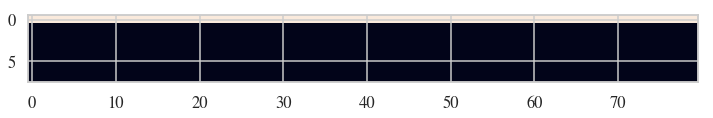

torch.Size([81, 1]) torch.Size([81, 196])


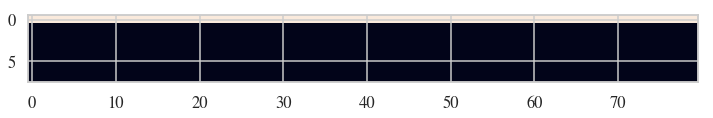

torch.Size([81, 1]) torch.Size([81, 196])


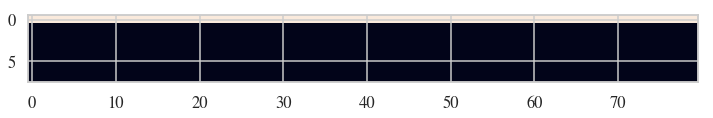

torch.Size([81, 1]) torch.Size([81, 196])


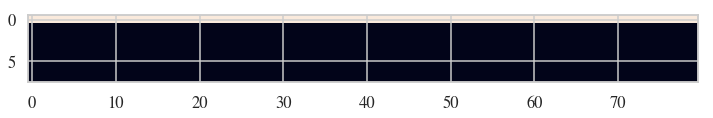

torch.Size([81, 1]) torch.Size([81, 196])


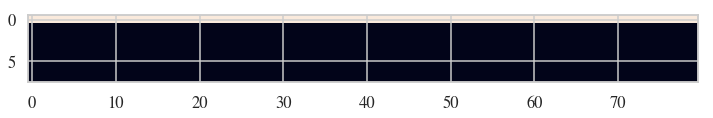

torch.Size([81, 1]) torch.Size([81, 196])


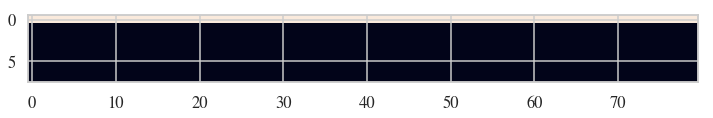

torch.Size([81, 1]) torch.Size([81, 196])


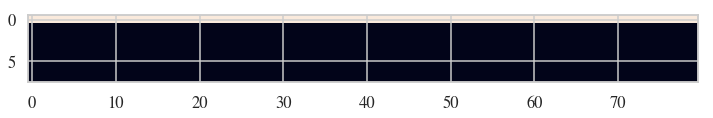

torch.Size([81, 1]) torch.Size([81, 196])


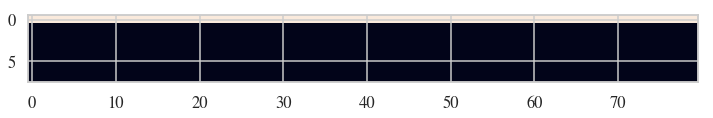

torch.Size([81, 1]) torch.Size([81, 196])


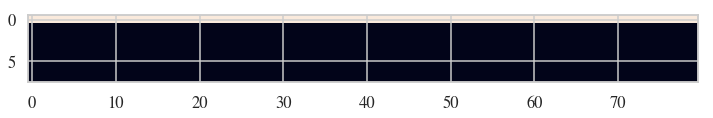

torch.Size([81, 1]) torch.Size([81, 196])


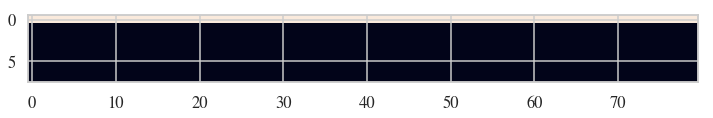

torch.Size([81, 1]) torch.Size([81, 196])


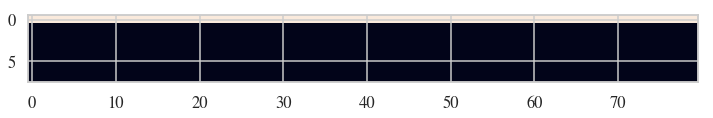

torch.Size([81, 1]) torch.Size([81, 196])


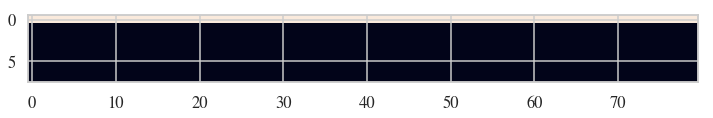

torch.Size([81, 1]) torch.Size([81, 196])


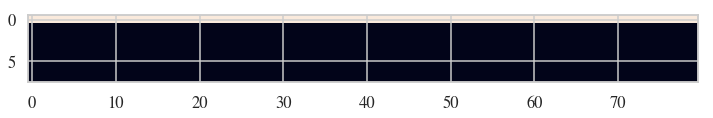

torch.Size([81, 1]) torch.Size([81, 196])


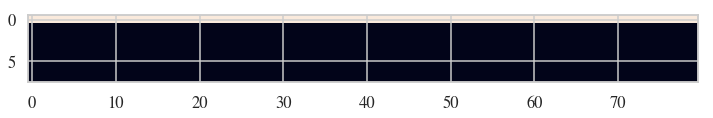

torch.Size([81, 1]) torch.Size([81, 196])


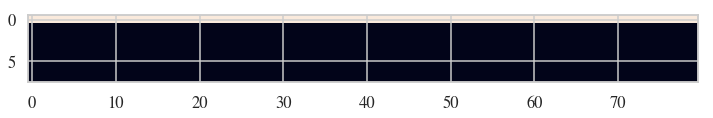

torch.Size([81, 1]) torch.Size([81, 196])


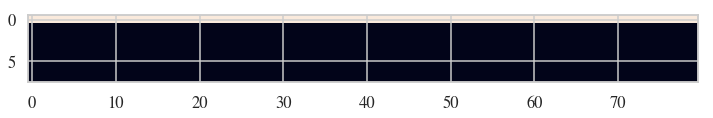

torch.Size([81, 1]) torch.Size([81, 196])


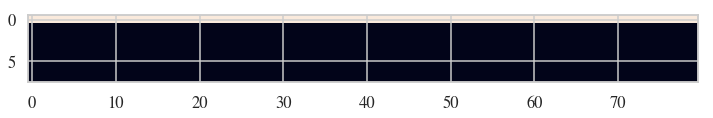

torch.Size([81, 1]) torch.Size([81, 196])


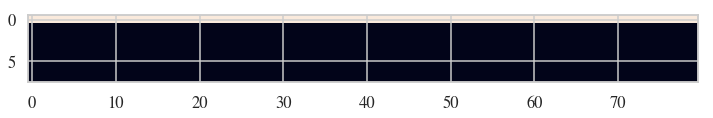

torch.Size([81, 1]) torch.Size([81, 196])


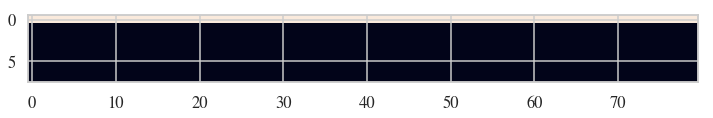

torch.Size([81, 1]) torch.Size([81, 196])


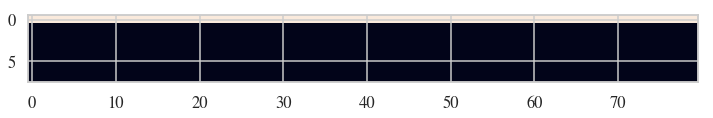

torch.Size([81, 1]) torch.Size([81, 196])



In [58]:
g = generate_graph(model=model, 
                   edge_nn=edge_nn,
                   max_prev_node=max_prev_node, 
                   test_batch_energies=torch.tensor(np.random.uniform(0., 0., 20), dtype=torch.float32).to(device).view(-1, 1), 
                   device=device)

In [59]:
dZ = 205. # 0.0205 cm emulsion
DISTANCE = 1293.

def plot_npframe(data, azim=-84, elev=10):
    """
    Function for plotting shower
    """
    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d.art3d import Line3DCollection
    import matplotlib.pyplot as plt
    x0, y0, z0, sx, sy = data.T

    x1 = x0 + dZ * sx
    y1 = y0 + dZ * sy
    z1 = z0 + dZ
    
    start_points = np.array([z0, y0, x0]).T.reshape(-1, 3)
    end_points = np.array([z1, y1, x1]).T.reshape(-1, 3)

    C = plt.cm.Greys(1.)
    lc = Line3DCollection(list(zip(start_points, end_points)), colors=C, alpha=0.9, lw=3)

    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=azim, elev=elev)
    ax.add_collection3d(lc)
    
    ax.set_xlabel("z")
    ax.set_ylabel("y")
    ax.set_zlabel("x")
    q = 2
    ax.set_xlim(np.percentile(z0, q=q), np.percentile(z1, q=100 - q))
    ax.set_ylim(np.percentile(y0, q=q), np.percentile(y1, q=100 - q))
    ax.set_zlim(np.percentile(x0, q=q), np.percentile(x1, q=100 - q))
    
    plt.tight_layout()
    plt.show()

In [60]:
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")
matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)

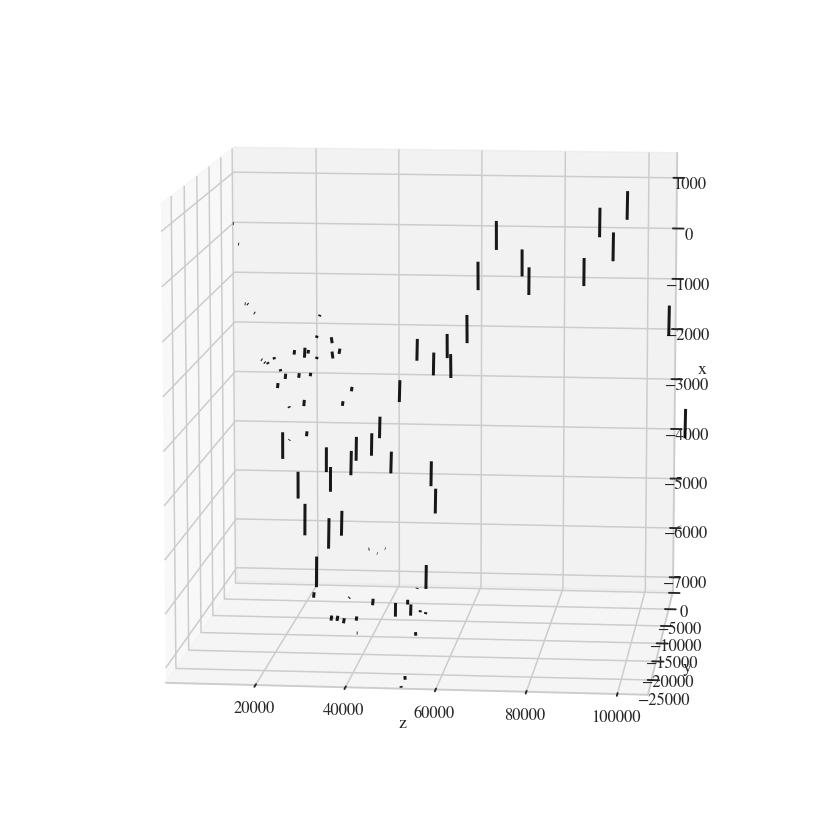

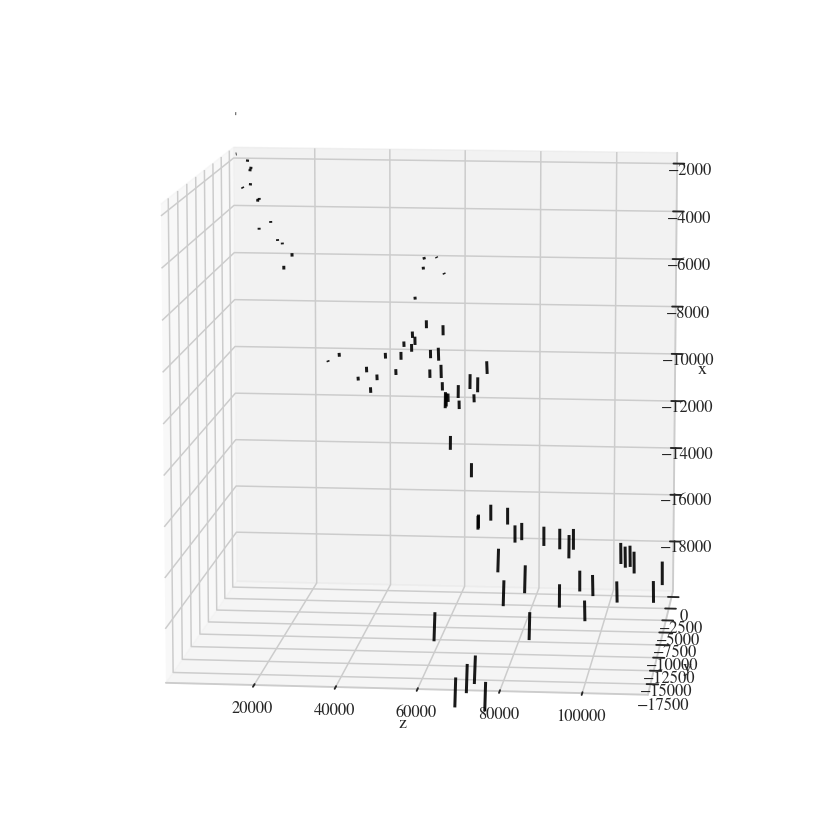

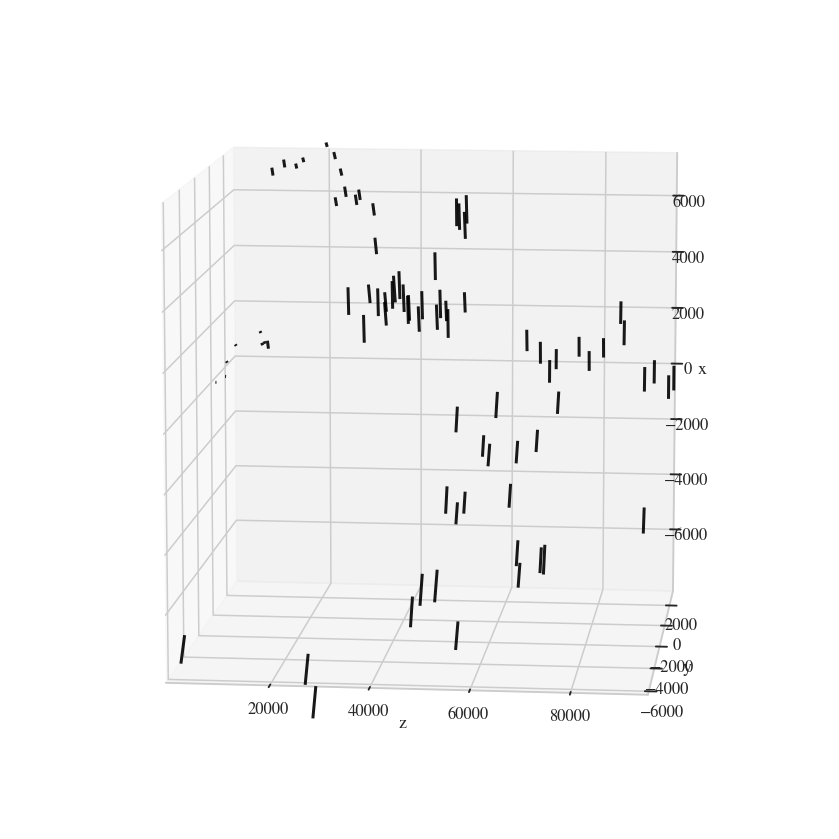

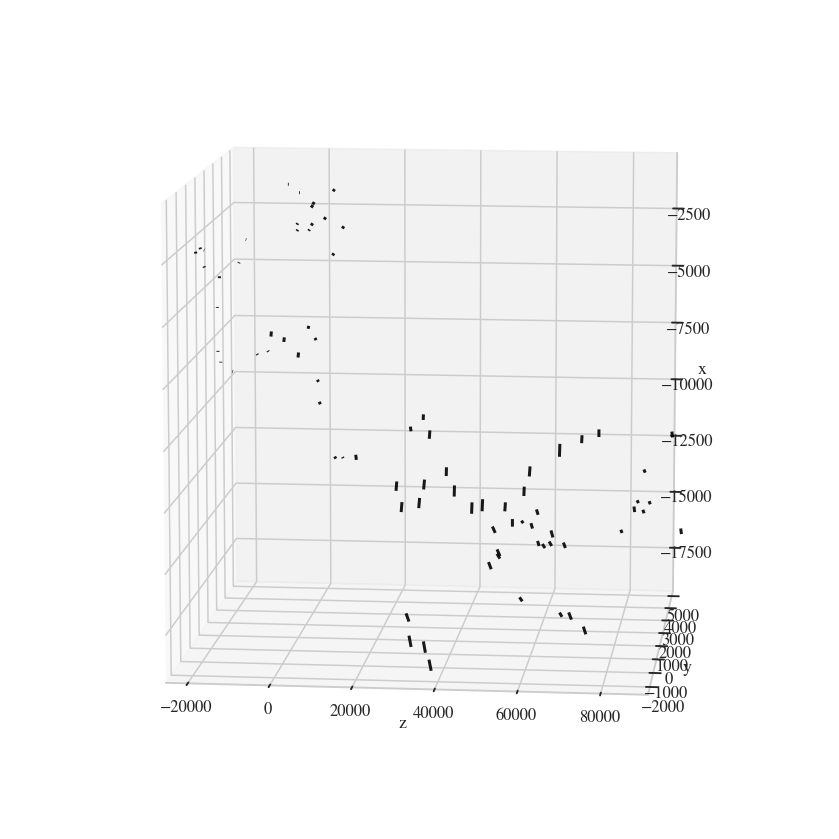

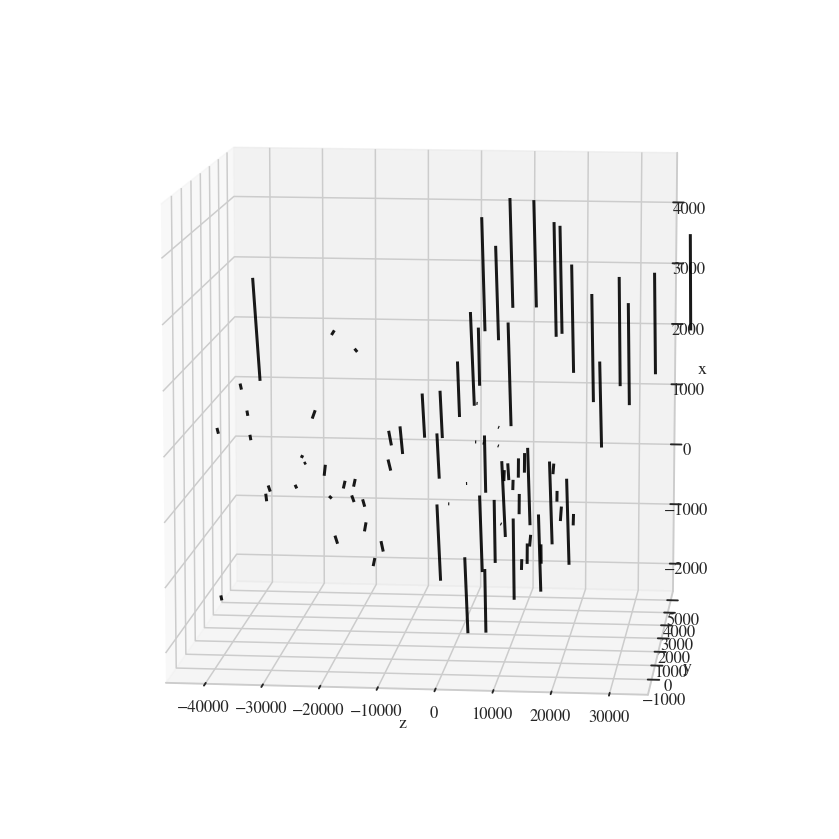

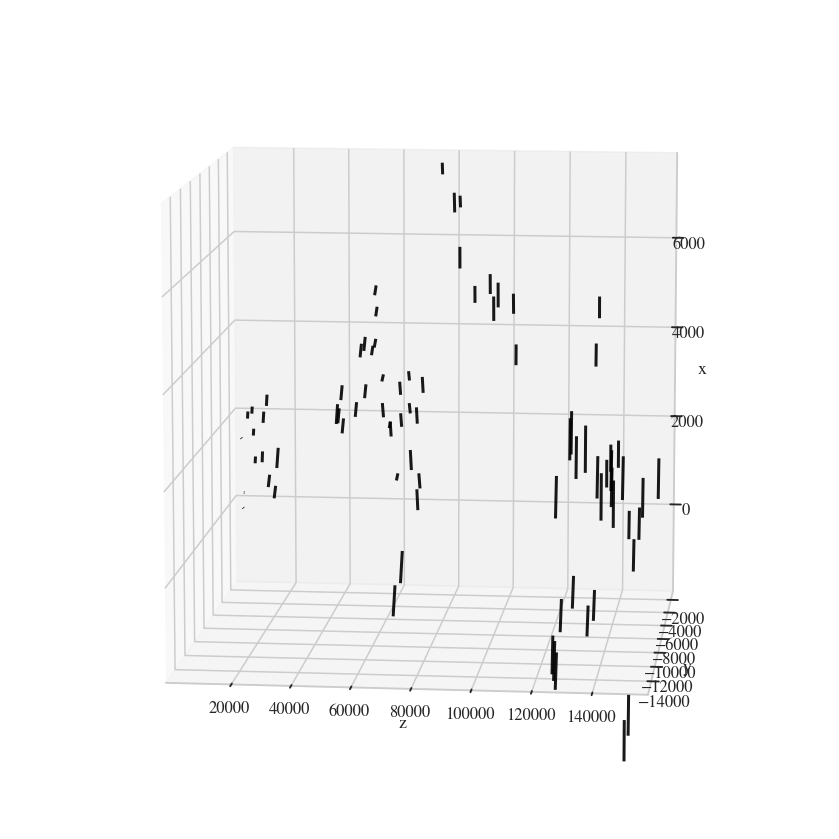

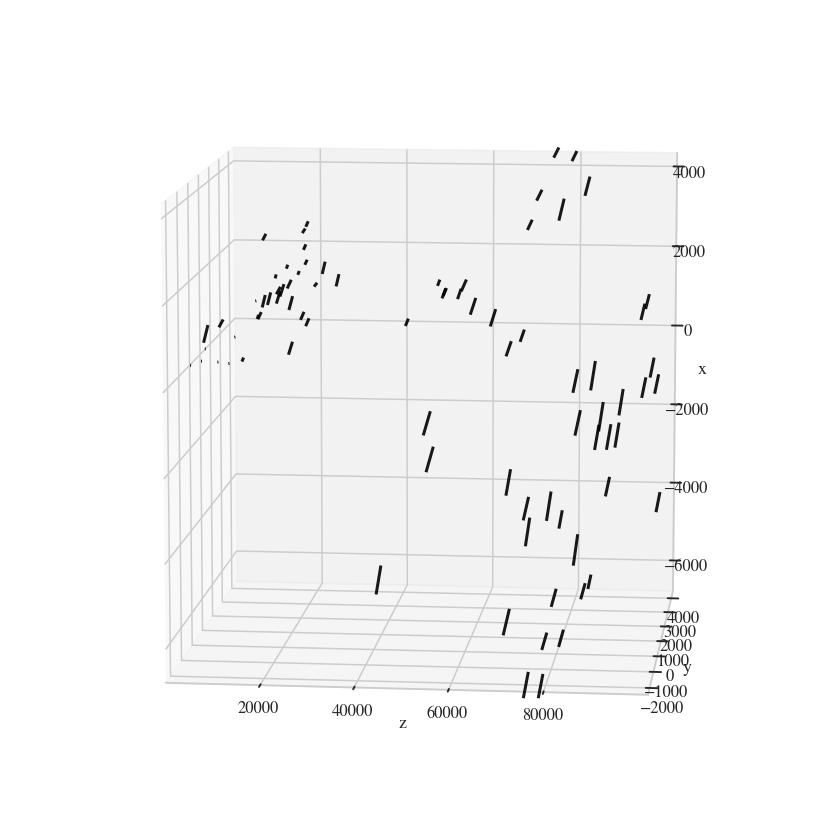

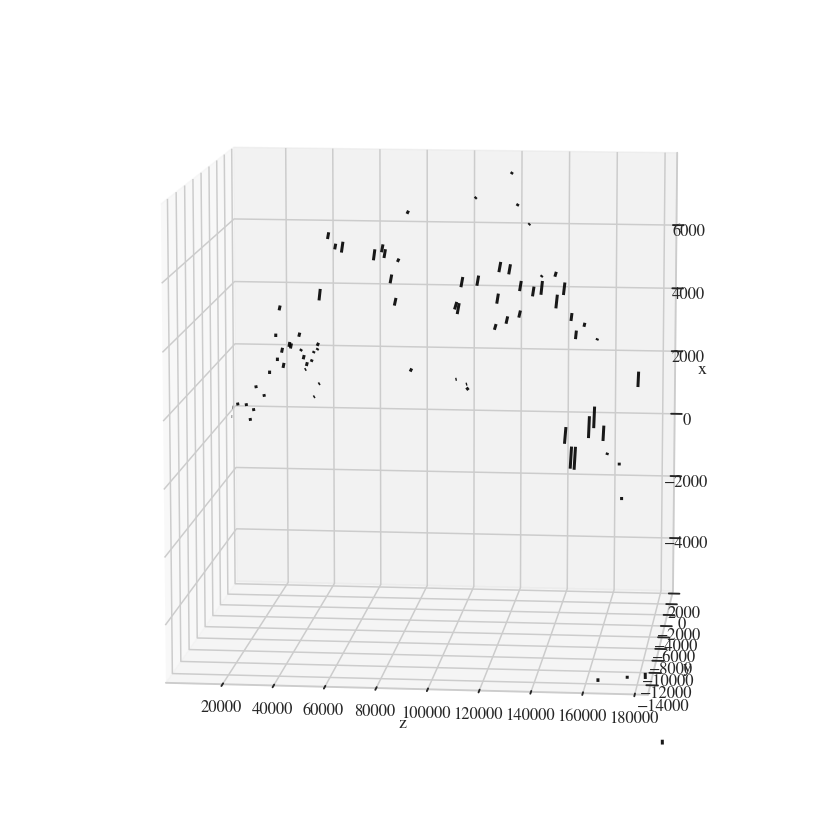

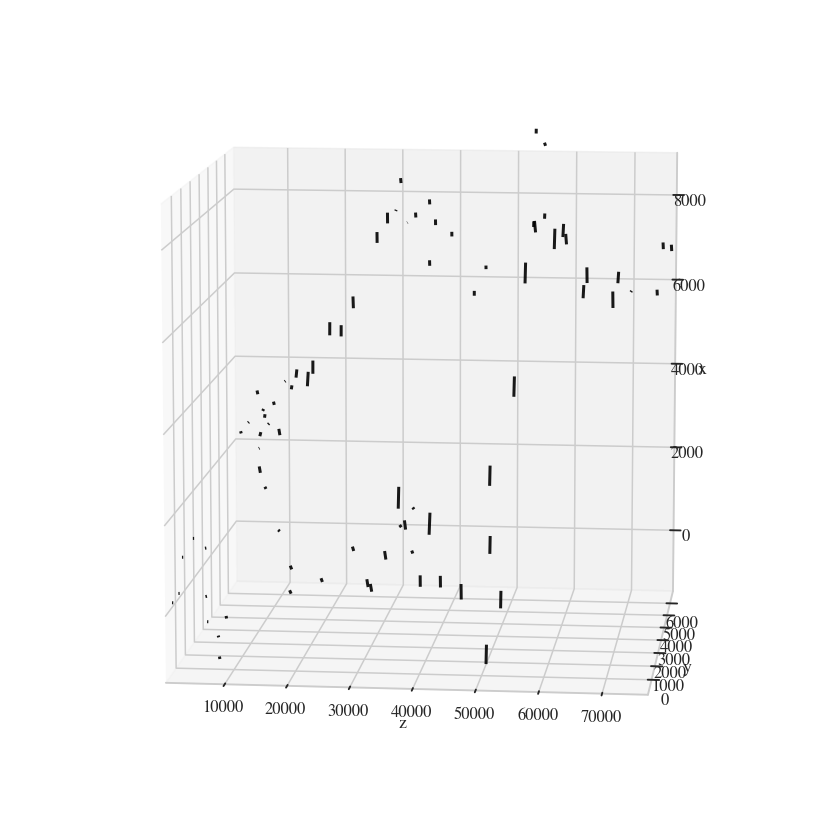

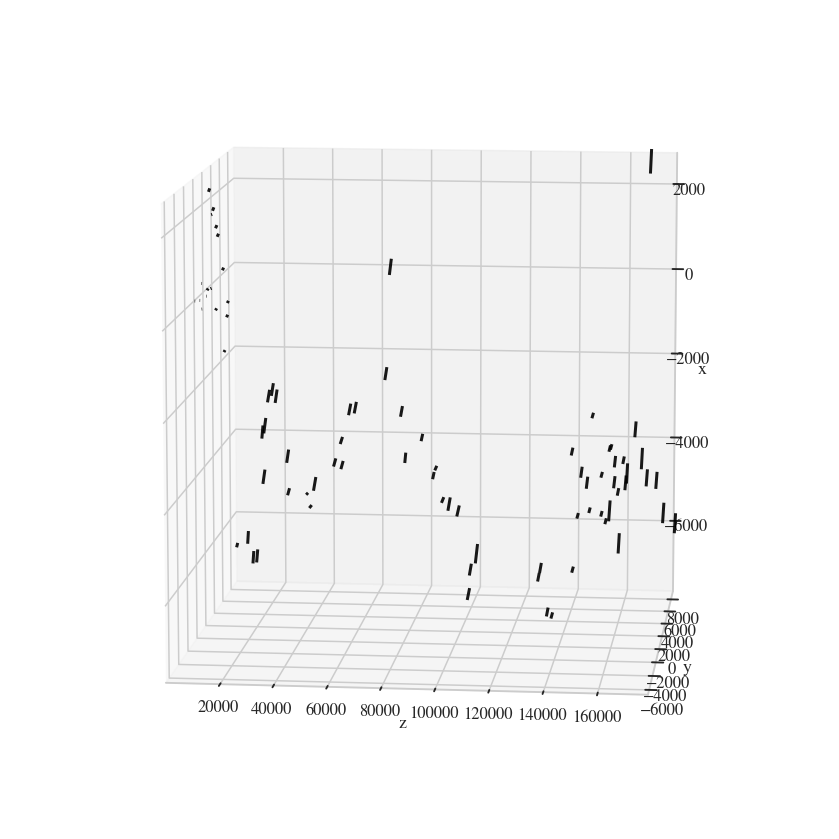

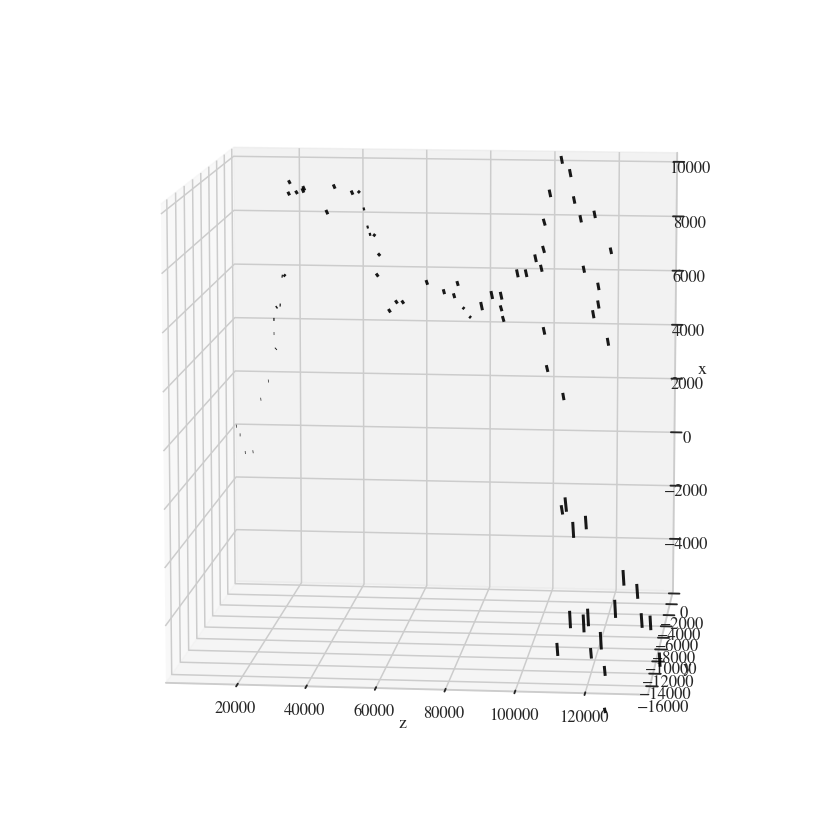

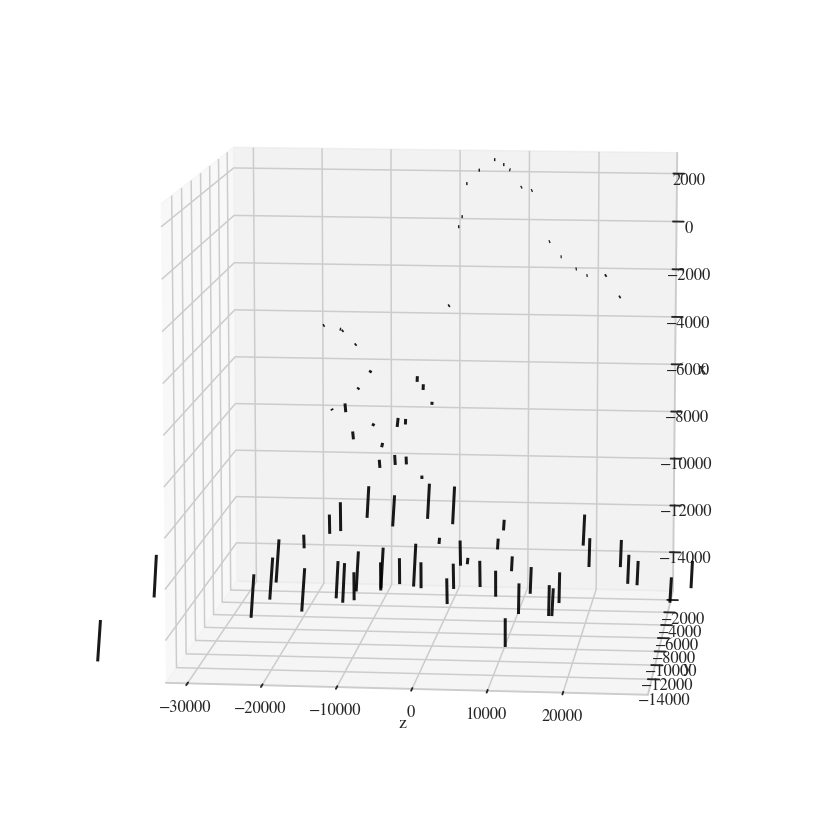

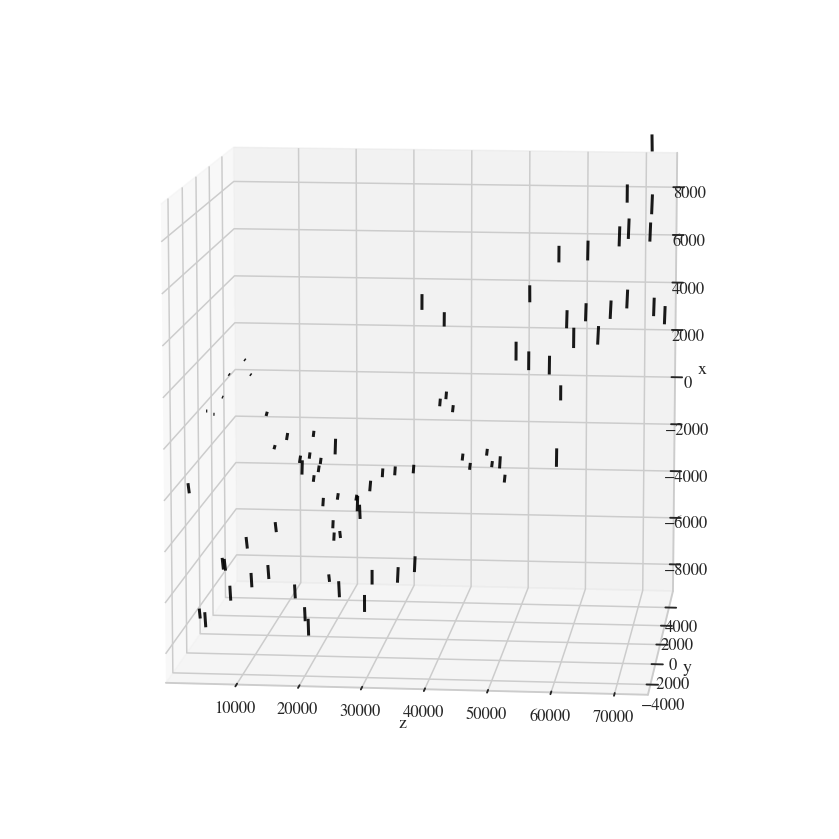

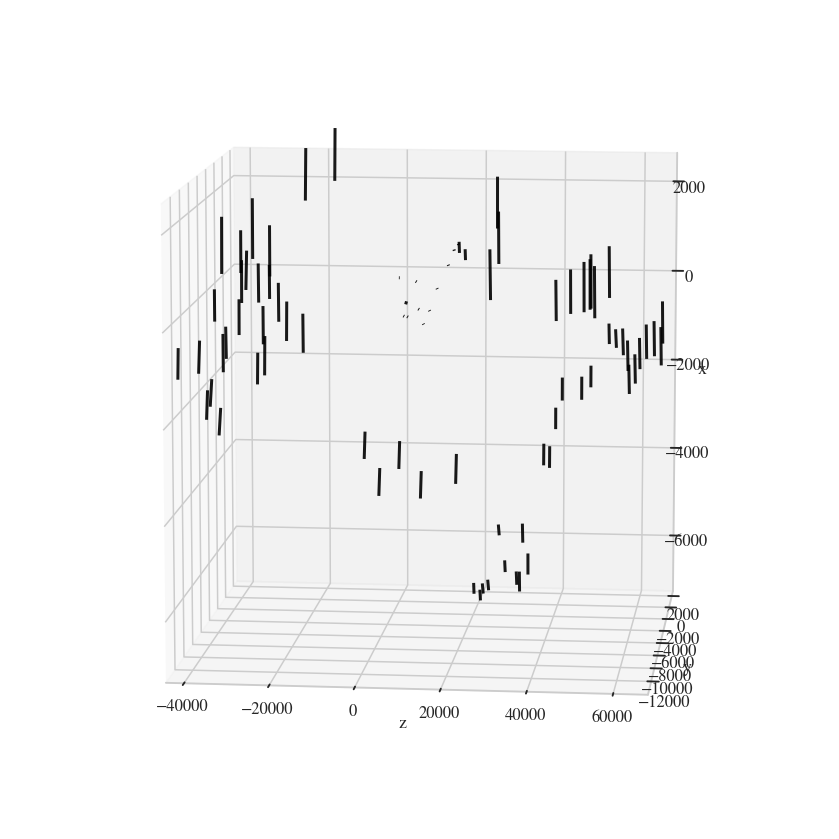

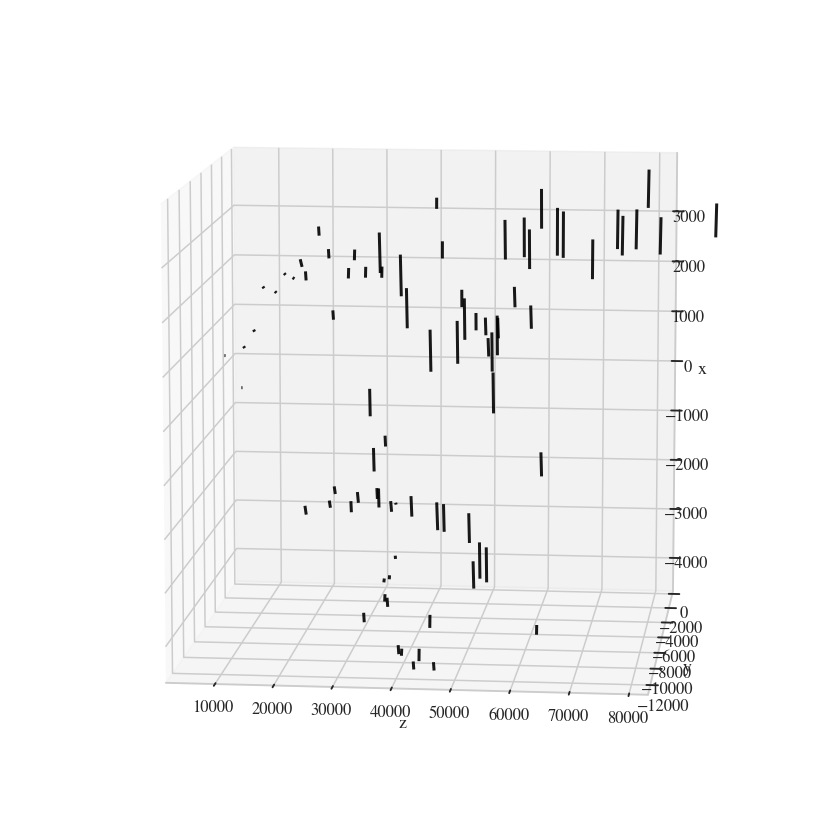

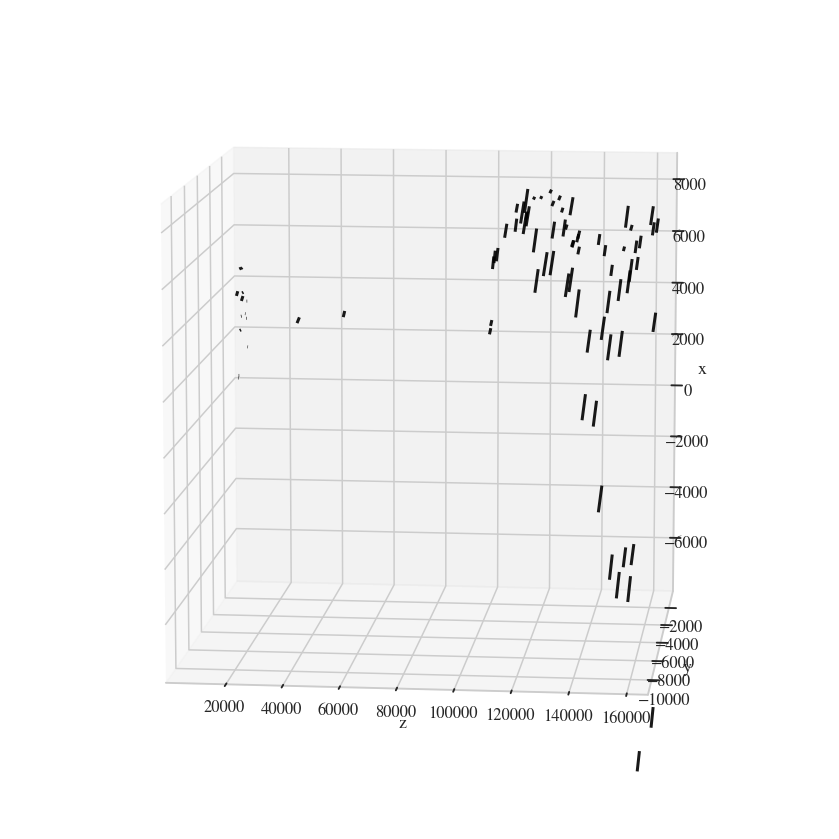

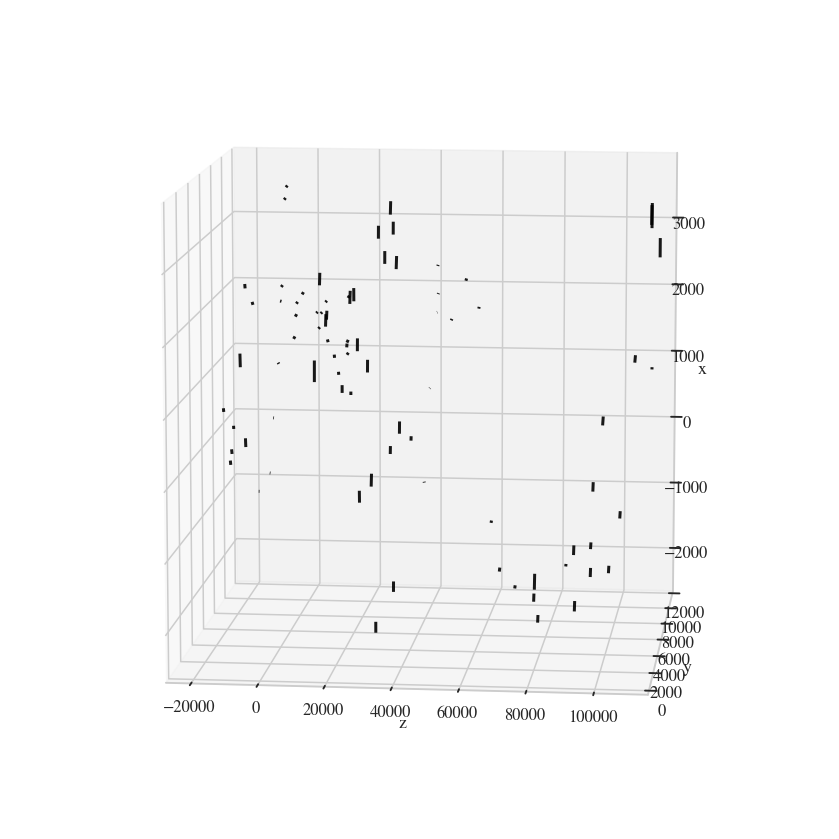

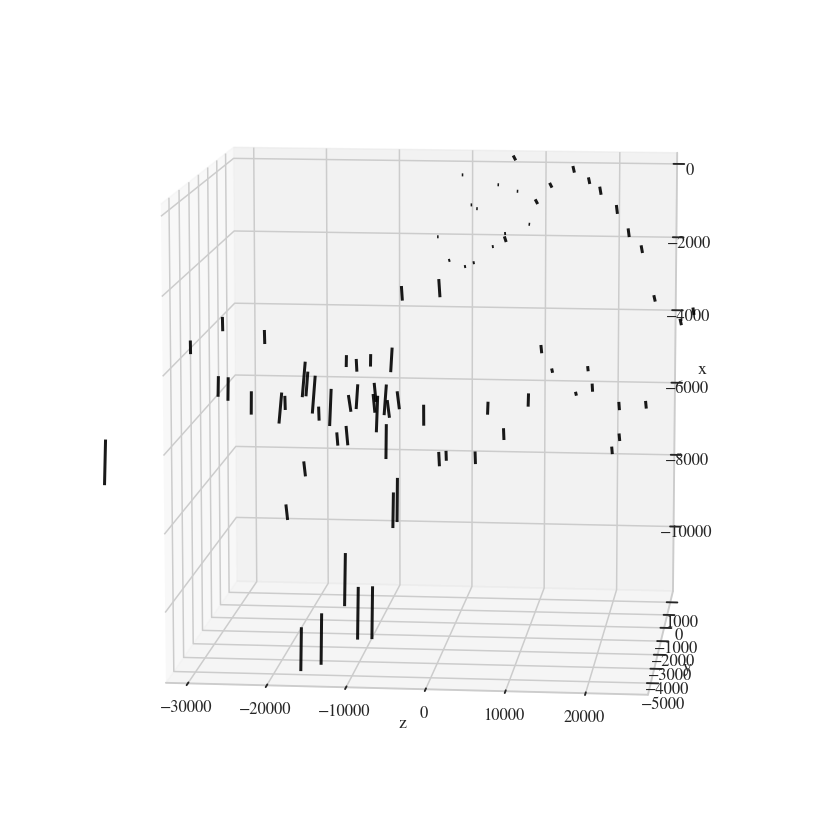

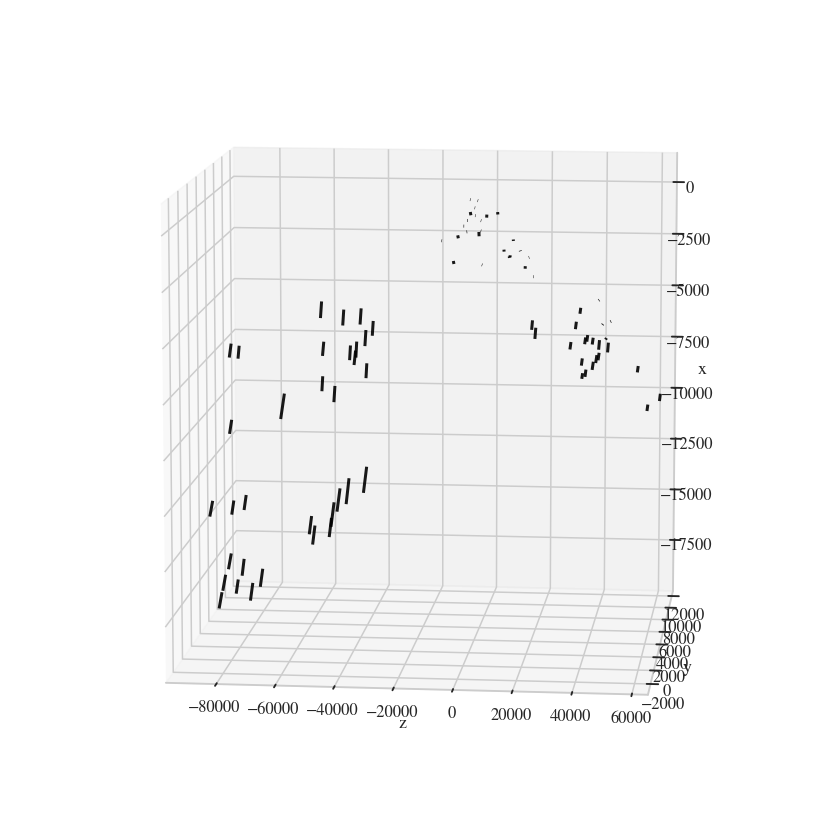

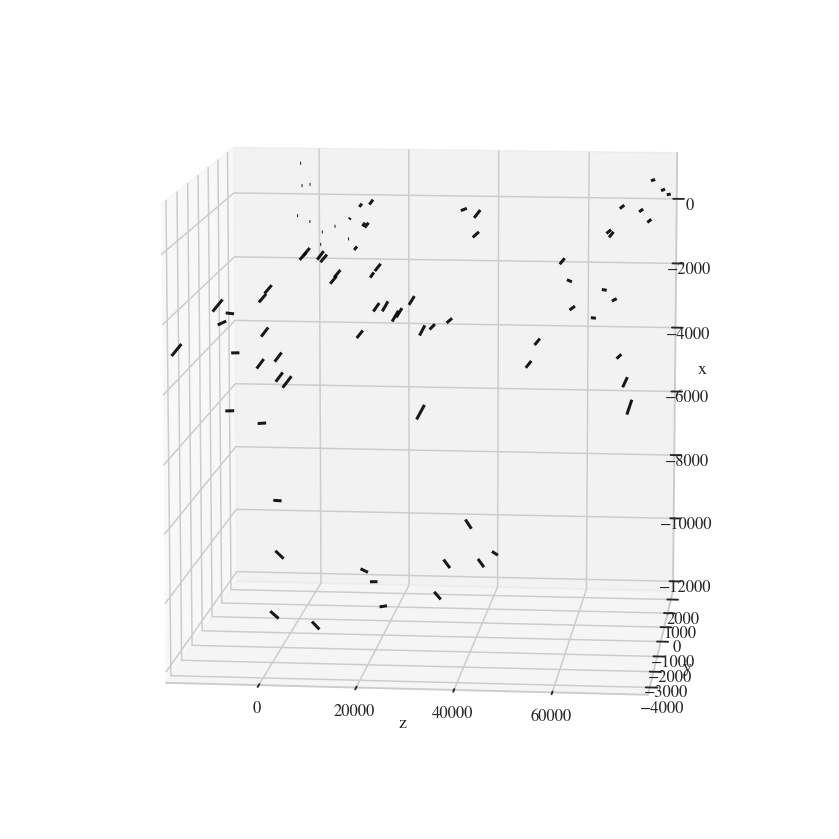

In [61]:
xs = []
for j in g:
    tmp_X = j
    tmp_X *= np.array([1e5, 1e5, 1e5, 1, 1])
    plot_npframe(tmp_X)    
    x = tmp_X[:, 0]
    xs.append(x)

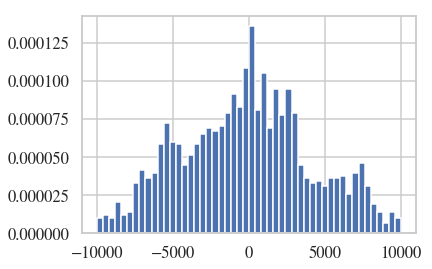

In [62]:
plt.hist(np.concatenate(xs), bins=50, range=(-10000, 10000), density=True);

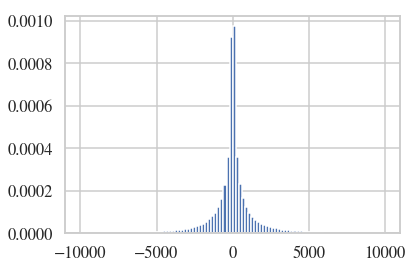

In [63]:
xs_real = []
for shower in showers:
    xs_real.append(shower.x['SX'].values)
plt.hist(np.concatenate(xs_real), bins=100, range=(-10000, 10000), density=True);

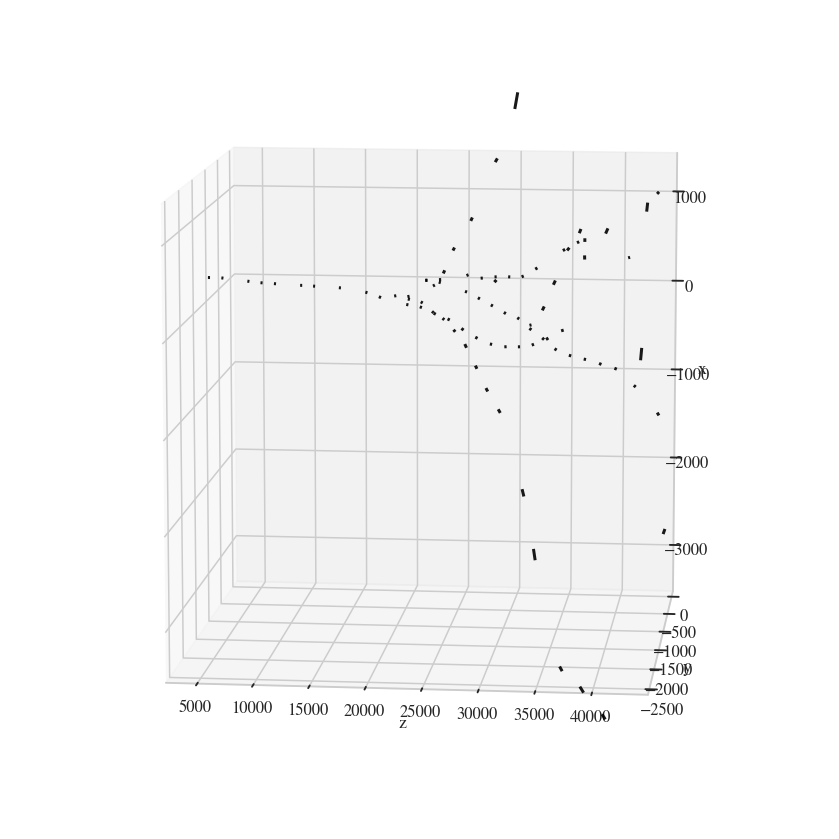

In [41]:
plot_npframe(showers[2].x[['SX', 'SY', 'SZ', 'TX', 'TY']].values)

In [42]:
len(showers[2].x[['SX', 'SY', 'SZ', 'TX', 'TY']].values)

84

In [43]:
adj = shower.adj.copy()

In [44]:
adj[np.tril_indices_from(adj)] = -1

In [45]:
shower.adj

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [46]:
adj.shape

(89, 89)

## 